## ENSO influence on Antarctic coastal ocean

In [2]:
# Load modules
%pylab inline
from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from os.path import expanduser
home = expanduser("~") # Get users home directory
import os # operating system interface
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats


Populating the interactive namespace from numpy and matplotlib


In [3]:
#extract the MOM model grid info - 50 and 75 vertical levels
hgrid_file ='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/mom025_ocean_grid.nc'
vgrid_file ='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/ocean.ncra501-520.nc'

# Extract the variables
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
area_t = nc.variables['area_t'][:]
dxt = nc.variables['dxt'][:]
dyt = nc.variables['dyt'][:]
kmu = nc.variables['kmu'][:]
kmt = nc.variables['kmt'][:]
ht = nc.variables['ht'][:]
fcor = nc.variables['f_coriolis'][:]
nc.close() # close the file
print geolon_t.shape

fh=fcor/ht
print fh.shape

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
sw_ocean = nc.variables['sw_ocean'][:]
st_ocean = nc.variables['st_ocean'][:]
yt_ocean = nc.variables['yt_ocean'][:]
yu_ocean = nc.variables['yu_ocean'][:]
xt_ocean = nc.variables['xt_ocean'][:]
potrho = nc.variables['potrho'][:]
nc.close() # close the file
print st_ocean.shape
print potrho.shape
print yt_ocean.shape

nc = Dataset('/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/output200/ocean.nc', mode='r') # file handle, open in read only mode
dzt = nc.variables['dzt'][0,:,:,:]
nc.close() # close the file

print dzt.shape
#dzt=np.squeeze(dzt)
#print dzt.shape


(1080, 1440)
(1080, 1440)
(50,)
(80,)
(1080,)
(50, 1080, 1440)


In [4]:
#A = xr.DataArray(np.arange(100))
#A.cumsum(axis=0)
print (xr.__version__)

#my xarray version is old, no cumsum. Should be version 0.9.2 or newer?

0.10.2


The Bellingshausen Sea is an area along the west side of the Antarctic Peninsula between 57°18'W and 102°20'W, west of Alexander Island, east of Cape Flying Fish on Thurston Island, and south of Peter I Island (there the southern Vostokkysten).

WAP range
i=821 to 872

BS range
i=716 to i=820

AS range
i=613 to i=714

In [5]:
NYFCntrlDir = '/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080_cp/'
#this has 3 years of a wind perturbation - get a nice 3 year polynya.
NYFPertDir = '/g/data1/v45/pas561/mom/archive/gfdl_nyf_iafAntSOI/'


In [6]:
Ocean_File = os.path.join(NYFCntrlDir,'output*/ocean.nc')
print Ocean_File
cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print cntrl.temp.shape


Ocean_File = os.path.join(NYFPertDir,'output*/ocean.nc')
print Ocean_File
pert=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print pert.temp.shape

/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080_cp/output*/ocean.nc
(50, 50, 1080, 1440)
/g/data1/v45/pas561/mom/archive/gfdl_nyf_iafAntSOI/output*/ocean.nc
(50, 50, 1080, 1440)


In [7]:
clev = np.arange(-.5,0.51,.01)
yrs=np.arange(1968,2018,1)
#print clev
print yrs.shape

print st_ocean[16]
st=16

yr = nonzero(yrs == 1973)[0][0]
print yrs[yr]
print yr

clev3 = np.arange(0,1500,1000)
print clev3
print yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4')

(50,)
201.262954712
1973
5
[   0 1000]
1973-1974


201.262954712
1972
4


/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


1982
14
1997
29
2015
47


/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


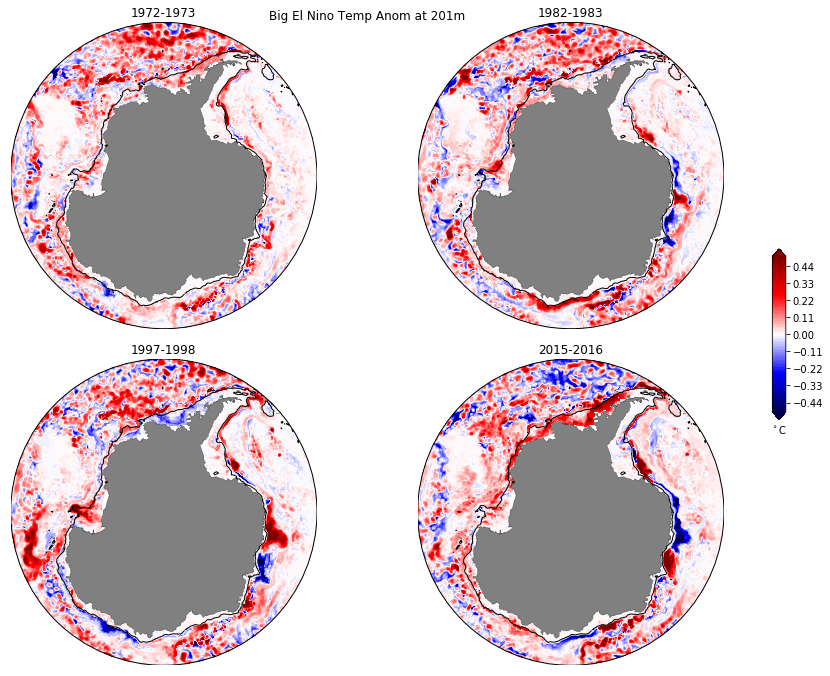

In [8]:
#plot temp anom
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Big El Nino Temp Anom at 201m')
clev = np.arange(-.5,0.51,.01)
yrs=np.arange(1968,2018,1)
print st_ocean[16]
st=16

yr = nonzero(yrs == 1972)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load()-cntrl.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1982)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load()-cntrl.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1997)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load()-cntrl.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2015)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load()-cntrl.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))


ax3 = plt.axes([0.95,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$^\circ$C')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'temp_EN_anom.png')
plt.savefig(of,dpi=220)



201.262954712
1972
4
1982
14
1997
29
2015
47


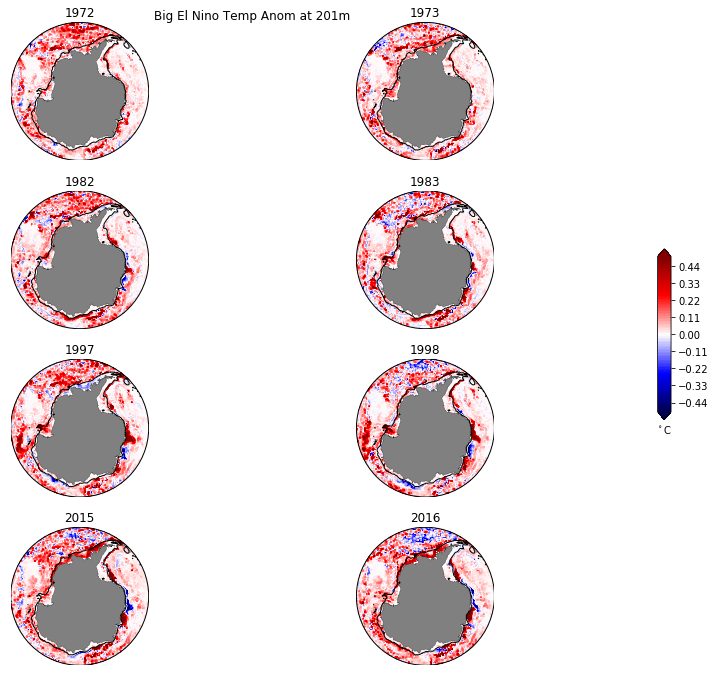

In [9]:
#plot temp anom
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Big El Nino Temp Anom at 201m')
clev = np.arange(-.5,0.51,.01)
yrs=np.arange(1968,2018,1)
print st_ocean[16]
st=16

yr = nonzero(yrs == 1972)[0][0]
print yrs[yr]
print yr

plt.subplot(4,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr,st,0:250,:].load()-cntrl.temp[yr,st,0:250,:].load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4'))

plt.subplot(4,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr+1,st,0:250,:].load()-cntrl.temp[yr+1,st,0:250,:].load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr+1].astype('S4'))


yr = nonzero(yrs == 1982)[0][0]
print yrs[yr]
print yr

plt.subplot(4,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr,st,0:250,:].load()-cntrl.temp[yr,st,0:250,:].load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4'))

plt.subplot(4,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr+1,st,0:250,:].load()-cntrl.temp[yr+1,st,0:250,:].load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1997)[0][0]
print yrs[yr]
print yr

plt.subplot(4,2,5)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr,st,0:250,:].load()-cntrl.temp[yr,st,0:250,:].load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4'))

plt.subplot(4,2,6)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr+1,st,0:250,:].load()-cntrl.temp[yr+1,st,0:250,:].load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2015)[0][0]
print yrs[yr]
print yr

plt.subplot(4,2,7)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr,st,0:250,:].load()-cntrl.temp[yr,st,0:250,:].load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4'))

plt.subplot(4,2,8)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr+1,st,0:250,:].load()-cntrl.temp[yr+1,st,0:250,:].load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr+1].astype('S4'))


ax3 = plt.axes([0.95,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$^\circ$C')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'temp_EN_anom2.png')
plt.savefig(of,dpi=220)



201.262954712
1988
20
1999
31
2007
39
2010
42


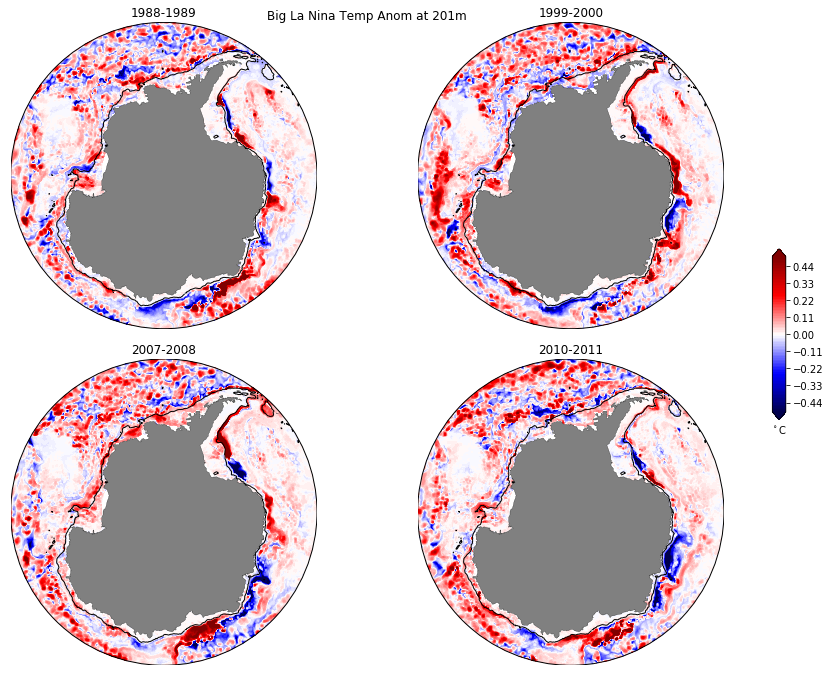

In [10]:
#plot temp anom
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Big La Nina Temp Anom at 201m')
clev = np.arange(-.5,0.51,.01)
yrs=np.arange(1968,2018,1)
print st_ocean[16]
st=16

yr = nonzero(yrs == 1988)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load()-cntrl.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1999)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load()-cntrl.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2007)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load()-cntrl.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2010)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load()-cntrl.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))


ax3 = plt.axes([0.95,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$^\circ$C')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'temp_LN_anom.png')
plt.savefig(of,dpi=220)



In [11]:
#now do time-series in each region.
#only for ht<1000m
of = os.path.join(NYFPertDir,'temp.cat01to25.diff.nc')
nc = Dataset(of, mode='r') # file handle, open in read only mode
tanom = nc.variables['temp'][:,:,0:250,:]
nc.close() # close the file

print tanom.shape


(50, 50, 250, 1440)


In [12]:
#Nan all values where ht>1000
#print ht.shape
#msk=ht[0:250,:].copy()
#print msk.shape
#msk[np.where(ht[0:250,:]>0)]=1
#msk[np.where(ht[0:250,:]>1000)]=NaN

print ht.shape
msk=np.ones((tanom.shape[2],tanom.shape[3]))
msk[np.where(ht[0:250,:]>1000)]=NaN
#print msk[:,1000]


tanom=tanom*msk

(1080, 1440)


(50, 50, 250, 1440)
201.262954712
1972
4


/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


1982
14
1997
29
2015
47


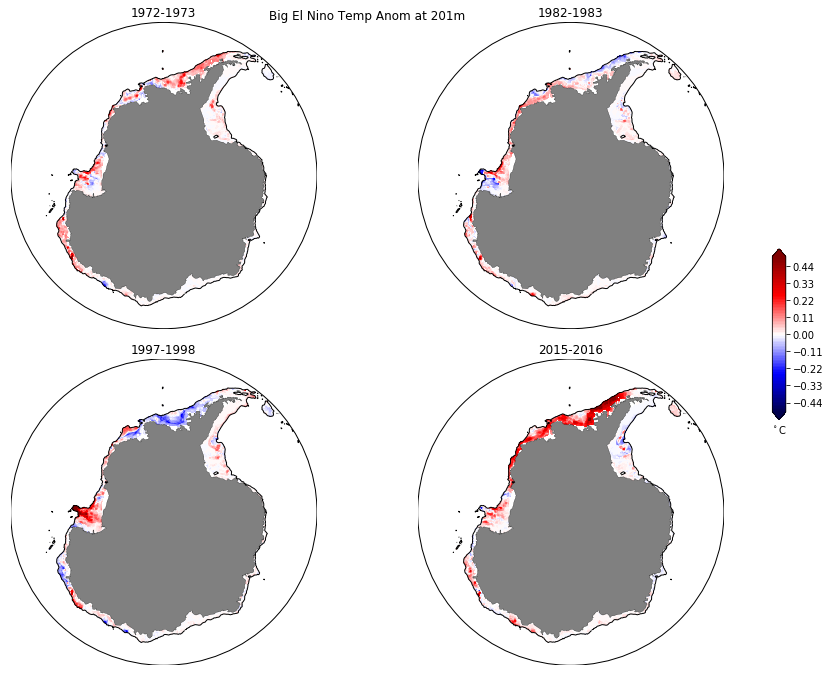

In [13]:
print tanom.shape

plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Big El Nino Temp Anom at 201m')
clev = np.arange(-.5,0.51,.01)
yrs=np.arange(1968,2018,1)
print st_ocean[16]
st=16

yr = nonzero(yrs == 1972)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,tanom[yr:yr+1,st,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1982)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,tanom[yr:yr+1,st,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1997)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,tanom[yr:yr+1,st,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2015)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,tanom[yr:yr+1,st,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))


ax3 = plt.axes([0.95,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$^\circ$C')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'temp_EN_anom.png')
plt.savefig(of,dpi=220)


(50, 50, 250, 1440)
201.262954712
1988
20
1999
31
2007
39
2010
42


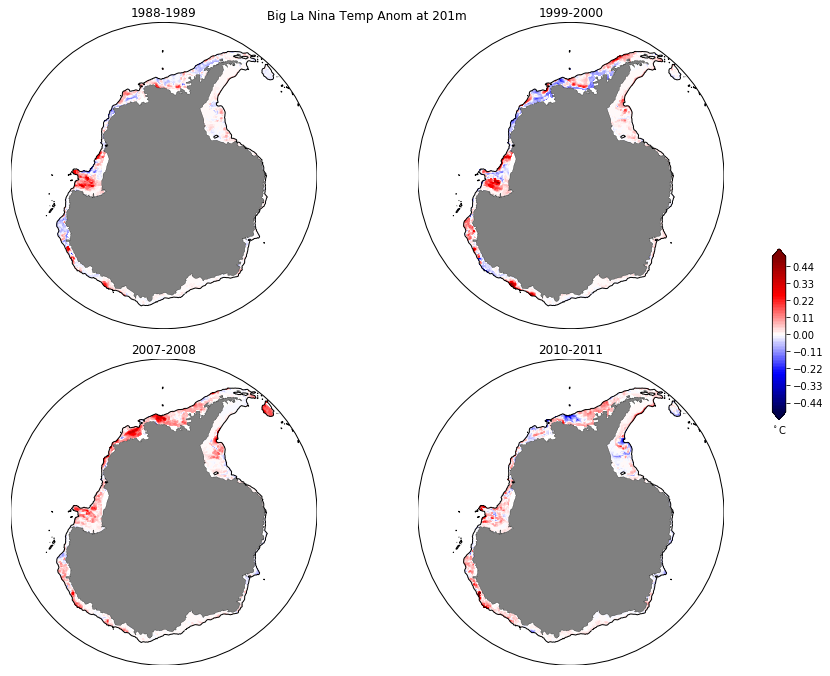

In [14]:
#plot temp anom
print tanom.shape

plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Big La Nina Temp Anom at 201m')
clev = np.arange(-.5,0.51,.01)
yrs=np.arange(1968,2018,1)
print st_ocean[16]
st=16

yr = nonzero(yrs == 1988)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,tanom[yr:yr+1,st,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1999)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,tanom[yr:yr+1,st,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2007)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,tanom[yr:yr+1,st,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2010)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,tanom[yr:yr+1,st,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))


ax3 = plt.axes([0.95,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$^\circ$C')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'temp_LN_anom.png')
plt.savefig(of,dpi=220)


In [15]:
print ht[0:50,1000]
print tanom[0,st,0:50,1000]
msk=np.ones((tanom.shape[2],tanom.shape[3]))
msk[np.where(ht[0:250,:]>1000)]=0
msk[np.where(ht[0:250,:]<0)]=0

print msk[0:50,1000]

[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 40.46738815307617
 40.46738815307617 81.59939575195312 151.8946533203125 223.08717346191406
 284.163818359375 342.7684326171875 381.96636962890625 397.6492614746094
 399.9978942871094]
[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -0.003059983253479004 -0.004214644432067871 -0.004436969757080078
 -0.0030657052993774414 -0.0012923479080200195 0.0012711286544799805]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [16]:
#WAP range
#i=821 to 872
#BS range
#i=716 to i=820
#AS range
#i=613 to i=714

msk=np.ones((tanom.shape[2],tanom.shape[3]))
msk[np.where(ht[0:250,:]>1000)]=0
msk[np.where(ht[0:250,:]<0)]=0

print np.nansum(area_t)
print st_ocean[st]

i1=821
i2=872
wap_tanom=np.zeros((50,1))
for yr in range(0,50):
    #print yrs[yr]
    wap_tanom[yr]=np.nansum(tanom[yr,st,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    tarea=np.sum(area_t[0:250,i1:i2]*msk[:,i1:i2])
    #print tarea
    wap_tanom[yr]=wap_tanom[yr]/tarea

print tarea
print wap_tanom

i1=716
i2=820
bs_tanom=np.zeros((50,1))
for yr in range(0,50):
    #print yrs[yr]
    bs_tanom[yr]=np.nansum(tanom[yr,st,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    tarea=np.sum(area_t[0:250,i1:i2]*msk[:,i1:i2])
    #print tarea
    bs_tanom[yr]=bs_tanom[yr]/tarea

print tarea
print bs_tanom

i1=613
i2=714
as_tanom=np.zeros((50,1))
for yr in range(0,50):
    #print yrs[yr]
    as_tanom[yr]=np.nansum(tanom[yr,st,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    tarea=np.sum(area_t[0:250,i1:i2]*msk[:,i1:i2])
    #print tarea
    as_tanom[yr]=as_tanom[yr]/tarea

print tarea
print as_tanom


5.07057e+14
201.262954712
366844120624.0
[[ 0.00049581]
 [ 0.01221222]
 [ 0.01681424]
 [ 0.01043347]
 [ 0.03290613]
 [ 0.04858142]
 [ 0.03378742]
 [ 0.01166806]
 [ 0.04104921]
 [ 0.03350903]
 [ 0.01892071]
 [ 0.02720849]
 [ 0.02075799]
 [-0.02752967]
 [-0.03383325]
 [-0.04054926]
 [-0.04606169]
 [-0.0215513 ]
 [-0.00686459]
 [-0.00074882]
 [-0.00636379]
 [-0.04678395]
 [-0.02604654]
 [-0.03598056]
 [-0.02858772]
 [-0.03205601]
 [-0.03070527]
 [-0.05080428]
 [-0.02838381]
 [-0.02270447]
 [ 0.00497184]
 [ 0.00494858]
 [-0.00841002]
 [-0.01513756]
 [ 0.03837097]
 [ 0.08485742]
 [ 0.06427075]
 [ 0.02840802]
 [ 0.00530028]
 [-0.00013648]
 [ 0.01114147]
 [ 0.00298064]
 [ 0.01416184]
 [ 0.0076045 ]
 [ 0.05400993]
 [ 0.10069452]
 [ 0.12271349]
 [ 0.08611021]
 [ 0.01843474]
 [-0.00453058]]
293159054104.0
[[-0.00422728]
 [ 0.01781237]
 [ 0.03542832]
 [ 0.00980686]
 [ 0.02510496]
 [ 0.06840703]
 [ 0.04409143]
 [ 0.01439274]
 [-0.00139109]
 [ 0.03291459]
 [ 0.0319871 ]
 [ 0.00912255]
 [ 0.01344684

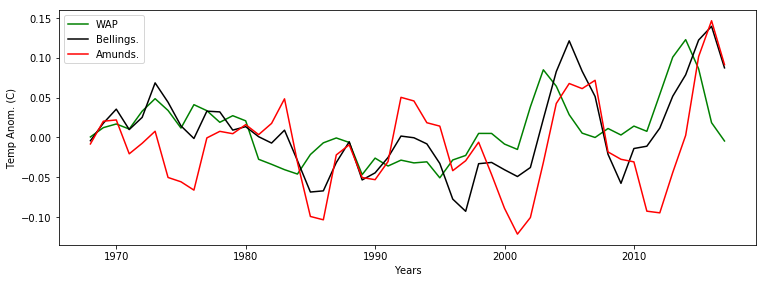

In [17]:
plt.subplot(211)
plt.plot(yrs,wap_tanom,linestyle='-',color='g',label='WAP',linewidth=1.5)
plt.plot(yrs,bs_tanom,linestyle='-',color='k',label='Bellings.',linewidth=1.5)
plt.plot(yrs,as_tanom,linestyle='-',color='r',label='Amunds.',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Temp Anom. (C)')
plt.xlabel('Years')
#plt.xlim([-75,85])
#plt.title('AMOC Rho Space')
plt.legend(fontsize=10)


In [18]:
#now do time-series in each region.
#only for ht<1000m
of = os.path.join(NYFPertDir,'temp.cat01to25.nc')
nc = Dataset(of, mode='r') # file handle, open in read only mode
tpert = nc.variables['temp'][:,st,0:250,:]
nc.close() # close the file

print tpert.shape
print ht.shape
msk=np.ones((tpert.shape[1],tpert.shape[2]))
msk[np.where(ht[0:250,:]>1000)]=NaN
#print msk[:,1000]

tpert=tpert*msk

#now do time-series in each region.
#only for ht<1000m
of = os.path.join(NYFCntrlDir,'temp.cat01to25.nc')
nc = Dataset(of, mode='r') # file handle, open in read only mode
tcntrl = nc.variables['temp'][:,st,0:250,:]
nc.close() # close the file

print tcntrl.shape
print ht.shape
msk=np.ones((tcntrl.shape[1],tcntrl.shape[2]))
msk[np.where(ht[0:250,:]>1000)]=NaN
#print msk[:,1000]

tcntrl=tcntrl*msk

(50, 250, 1440)
(1080, 1440)
(50, 250, 1440)
(1080, 1440)


(50, 250, 1440)
2015
47


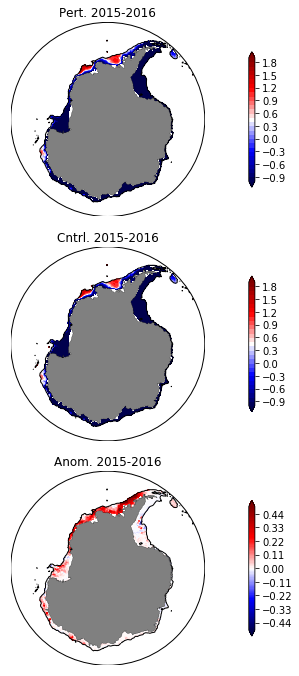

In [19]:
print tpert.shape

plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
yrs=np.arange(1968,2018,1)

yr = nonzero(yrs == 2015)[0][0]
print yrs[yr]
print yr

clev = np.arange(-1,2,.1)

plt.subplot(3,1,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,tpert[yr:yr+1,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title('Pert. '+yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

plt.subplot(3,1,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,tcntrl[yr:yr+1,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title('Cntrl. '+yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

clev = np.arange(-.5,0.51,.01)
plt.subplot(3,1,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,tpert[yr:yr+1,:,:].mean(axis=0)-tcntrl[yr:yr+1,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title('Anom. '+yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

#ax3 = plt.axes([0.95,0.38,0.015,0.25])
#cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
#cb.ax.set_xlabel('$^\circ$C')

plt.tight_layout()

In [20]:
msk=np.ones((tpert.shape[1],tpert.shape[2]))
msk[np.where(ht[0:250,:]>1000)]=0
msk[np.where(ht[0:250,:]<0)]=0

print np.nansum(area_t)
print st_ocean[st]

i1=821
i2=872
wap_tpert=np.zeros((50,1))
for yr in range(0,50):
    #print yrs[yr]
    wap_tpert[yr]=np.nansum(tpert[yr,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    tarea=np.sum(area_t[0:250,i1:i2]*msk[:,i1:i2])
    #print tarea
    wap_tpert[yr]=wap_tpert[yr]/tarea

print tarea
print wap_tpert

i1=716
i2=820
bs_tpert=np.zeros((50,1))
for yr in range(0,50):
    #print yrs[yr]
    bs_tpert[yr]=np.nansum(tpert[yr,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    tarea=np.sum(area_t[0:250,i1:i2]*msk[:,i1:i2])
    #print tarea
    bs_tpert[yr]=bs_tpert[yr]/tarea

print tarea
print bs_tpert

i1=613
i2=714
as_tpert=np.zeros((50,1))
for yr in range(0,50):
    #print yrs[yr]
    as_tpert[yr]=np.nansum(tpert[yr,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    tarea=np.sum(area_t[0:250,i1:i2]*msk[:,i1:i2])
    #print tarea
    as_tpert[yr]=as_tpert[yr]/tarea

print tarea
print as_tpert


5.07057e+14
201.262954712
366844120624.0
[[ 0.47945948]
 [ 0.49074357]
 [ 0.50212971]
 [ 0.50010428]
 [ 0.50621624]
 [ 0.51982931]
 [ 0.50981624]
 [ 0.49669915]
 [ 0.5191069 ]
 [ 0.53077636]
 [ 0.51302943]
 [ 0.50805734]
 [ 0.49916822]
 [ 0.47747744]
 [ 0.47504527]
 [ 0.46576541]
 [ 0.44469093]
 [ 0.45770362]
 [ 0.46673564]
 [ 0.470632  ]
 [ 0.47942677]
 [ 0.46748351]
 [ 0.47491412]
 [ 0.46876292]
 [ 0.4688026 ]
 [ 0.48024811]
 [ 0.47680166]
 [ 0.47628973]
 [ 0.48368882]
 [ 0.49326314]
 [ 0.5116663 ]
 [ 0.49284104]
 [ 0.48524488]
 [ 0.49108394]
 [ 0.52639027]
 [ 0.55611919]
 [ 0.53607667]
 [ 0.51500775]
 [ 0.49521481]
 [ 0.48521374]
 [ 0.47216582]
 [ 0.45894693]
 [ 0.47753216]
 [ 0.47155247]
 [ 0.51594818]
 [ 0.54743408]
 [ 0.60238138]
 [ 0.58276372]
 [ 0.53437234]
 [ 0.50168964]]
293159054104.0
[[ 0.04730306]
 [ 0.0751291 ]
 [ 0.10587521]
 [ 0.10683791]
 [ 0.13132536]
 [ 0.17035064]
 [ 0.14205279]
 [ 0.10087908]
 [ 0.08533414]
 [ 0.1266505 ]
 [ 0.13643733]
 [ 0.12468783]
 [ 0.12822217

In [21]:

msk=np.ones((tcntrl.shape[1],tcntrl.shape[2]))
msk[np.where(ht[0:250,:]>1000)]=0
msk[np.where(ht[0:250,:]<0)]=0

print np.nansum(area_t)
print st_ocean[st]

i1=821
i2=872
wap_tcntrl=np.zeros((50,1))
for yr in range(0,50):
    #print yrs[yr]
    wap_tcntrl[yr]=np.nansum(tcntrl[yr,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    tarea=np.sum(area_t[0:250,i1:i2]*msk[:,i1:i2])
    #print tarea
    wap_tcntrl[yr]=wap_tcntrl[yr]/tarea

print tarea
print wap_tcntrl

i1=716
i2=820
bs_tcntrl=np.zeros((50,1))
for yr in range(0,50):
    #print yrs[yr]
    bs_tcntrl[yr]=np.nansum(tcntrl[yr,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    tarea=np.sum(area_t[0:250,i1:i2]*msk[:,i1:i2])
    #print tarea
    bs_tcntrl[yr]=bs_tcntrl[yr]/tarea

print tarea
print bs_tcntrl

i1=613
i2=714
as_tcntrl=np.zeros((50,1))
for yr in range(0,50):
    #print yrs[yr]
    as_tcntrl[yr]=np.nansum(tcntrl[yr,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    tarea=np.sum(area_t[0:250,i1:i2]*msk[:,i1:i2])
    #print tarea
    as_tcntrl[yr]=as_tcntrl[yr]/tarea

print tarea
print as_tcntrl


5.07057e+14
201.262954712
366844120624.0
[[ 0.47896366]
 [ 0.47853136]
 [ 0.48531547]
 [ 0.4896708 ]
 [ 0.47331011]
 [ 0.47124789]
 [ 0.47602882]
 [ 0.48503109]
 [ 0.47805769]
 [ 0.49726733]
 [ 0.49410872]
 [ 0.48084885]
 [ 0.47841023]
 [ 0.50500711]
 [ 0.50887853]
 [ 0.50631467]
 [ 0.49075263]
 [ 0.47925492]
 [ 0.47360023]
 [ 0.47138082]
 [ 0.48579056]
 [ 0.51426747]
 [ 0.50096065]
 [ 0.50474348]
 [ 0.49739032]
 [ 0.51230412]
 [ 0.50750693]
 [ 0.52709401]
 [ 0.51207264]
 [ 0.51596761]
 [ 0.50669446]
 [ 0.48789246]
 [ 0.49365489]
 [ 0.5062215 ]
 [ 0.4880193 ]
 [ 0.47126177]
 [ 0.47180592]
 [ 0.48659973]
 [ 0.48991453]
 [ 0.48535022]
 [ 0.46102435]
 [ 0.45596629]
 [ 0.46337031]
 [ 0.46394797]
 [ 0.46193825]
 [ 0.44673956]
 [ 0.47966789]
 [ 0.4966535 ]
 [ 0.5159376 ]
 [ 0.50622022]]
293159054104.0
[[ 0.05153034]
 [ 0.05731674]
 [ 0.0704469 ]
 [ 0.09703106]
 [ 0.1062204 ]
 [ 0.1019436 ]
 [ 0.09796136]
 [ 0.08648634]
 [ 0.08672523]
 [ 0.0937359 ]
 [ 0.10445023]
 [ 0.11556529]
 [ 0.11477533

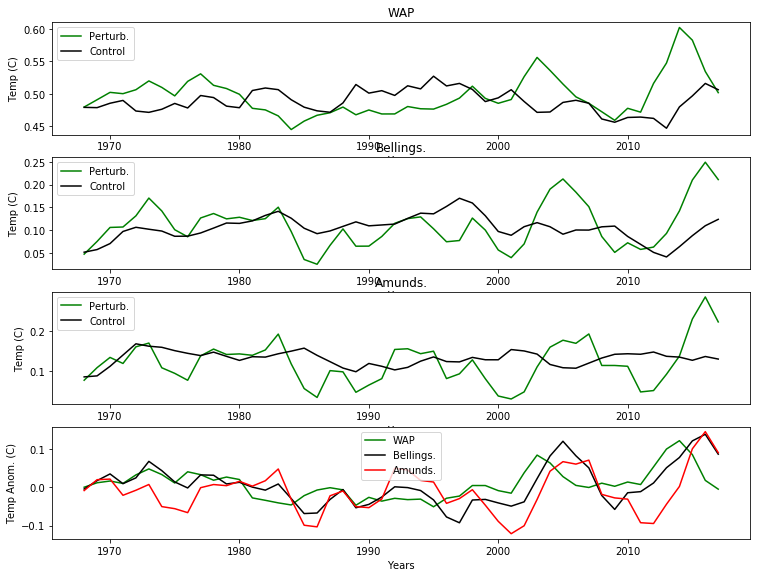

In [22]:
plt.subplot(411)
plt.plot(yrs,wap_tpert,linestyle='-',color='g',label='Perturb.',linewidth=1.5)
plt.plot(yrs,wap_tcntrl,linestyle='-',color='k',label='Control',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Temp (C)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('WAP')
plt.legend(fontsize=10)

plt.subplot(412)
plt.plot(yrs,bs_tpert,linestyle='-',color='g',label='Perturb.',linewidth=1.5)
plt.plot(yrs,bs_tcntrl,linestyle='-',color='k',label='Control',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Temp (C)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('Bellings.')
plt.legend(fontsize=10)

plt.subplot(413)
plt.plot(yrs,as_tpert,linestyle='-',color='g',label='Perturb.',linewidth=1.5)
plt.plot(yrs,as_tcntrl,linestyle='-',color='k',label='Control',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Temp (C)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('Amunds.')
plt.legend(fontsize=10)

plt.subplot(414)
plt.plot(yrs,wap_tpert-wap_tcntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
plt.plot(yrs,bs_tpert-bs_tcntrl,linestyle='-',color='k',label='Bellings.',linewidth=1.5)
plt.plot(yrs,as_tpert-as_tcntrl,linestyle='-',color='r',label='Amunds.',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Temp Anom. (C)')
plt.xlabel('Years')
#plt.xlim([-75,85])
#plt.title('AMOC Rho Space')
plt.legend(fontsize=10)

of = os.path.join(NYFPertDir,'temp_ENSO_ts_anom.png')
plt.savefig(of,dpi=220)

In [54]:
#Do tau_x and ssh time-series in each region.
#only for ht<1000m
of = os.path.join(NYFPertDir,'tx_ssh.cat01to25.nc')
nc = Dataset(of, mode='r') # file handle, open in read only mode
tx_pert = nc.variables['tau_x'][:,0:250,:]
ssh_pert = nc.variables['sea_level'][:,0:250,:]
nc.close() # close the file

print tx_pert.shape
print ht.shape
msk=np.ones((tx_pert.shape[1],tx_pert.shape[2]))
msk[np.where(ht[0:250,:]>1000)]=NaN
#print msk[:,1000]

#tx_pert=tx_pert*msk
#ssh_pert=ssh_pert*msk

print NYFCntrlDir

of = os.path.join(NYFCntrlDir,'tx_ssh.cat01to25.nc')
nc = Dataset(of, mode='r') # file handle, open in read only mode
ssh_cntrl = nc.variables['sea_level'][:,0:250,:]
tx_cntrl = nc.variables['tau_x'][:,0:250,:]
nc.close() # close the file

print tx_cntrl.shape
print ht.shape
msk=np.ones((tx_cntrl.shape[1],tx_cntrl.shape[2]))
msk[np.where(ht[0:250,:]>1000)]=NaN
#print msk[:,1000]

#tx_cntrl=tx_cntrl*msk
#ssh_cntrl=ssh_cntrl*msk

(50, 250, 1440)
(1080, 1440)
/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080_cp/
(50, 250, 1440)
(1080, 1440)


(50, 250, 1440)
1997
29


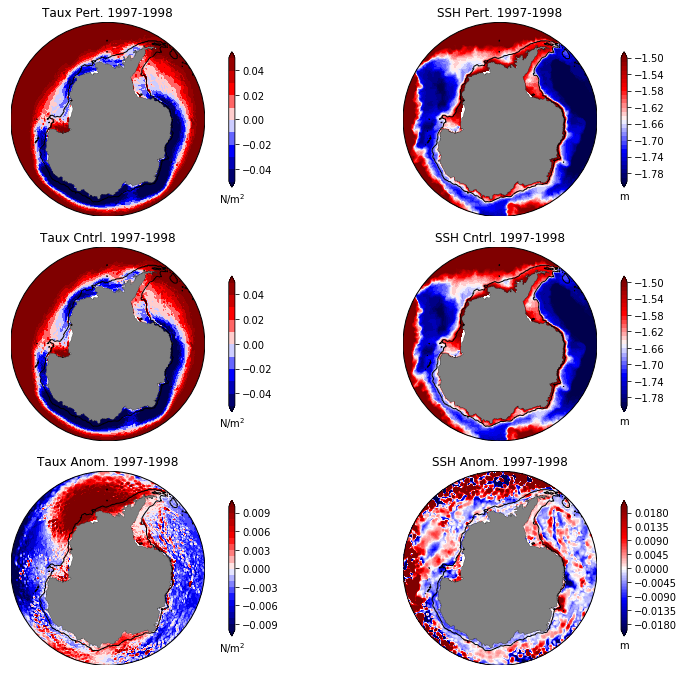

In [55]:
print tx_pert.shape

plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
yrs=np.arange(1968,2018,1)

yr = nonzero(yrs == 1997)[0][0]
print yrs[yr]
print yr

clev = np.arange(-.05,.051,.01)

plt.subplot(3,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,tx_pert[yr:yr+1,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('N/m$^2$')
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title('Taux Pert. '+yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

plt.subplot(3,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,tx_cntrl[yr:yr+1,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('N/m$^2$')
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title('Taux Cntrl. '+yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

clev = np.arange(-.01,0.011,.001)
plt.subplot(3,2,5)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,tx_pert[yr:yr+1,:,:].mean(axis=0)-tx_cntrl[yr:yr+1,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('N/m$^2$')
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title('Taux Anom. '+yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))


clev = np.arange(-1.8,-1.5,.01)

plt.subplot(3,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,ssh_pert[yr:yr+1,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('m')
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title('SSH Pert. '+yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

plt.subplot(3,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,ssh_cntrl[yr:yr+1,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('m')
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title('SSH Cntrl. '+yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

clev = np.arange(-0.02,0.0205,.0005)
plt.subplot(3,2,6)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,ssh_pert[yr:yr+1,:,:].mean(axis=0)-ssh_cntrl[yr:yr+1,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('m')
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title('SSH Anom. '+yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

#ax3 = plt.axes([0.95,0.38,0.015,0.25])
#cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
#cb.ax.set_xlabel('$^\circ$C')

plt.tight_layout()

(50, 250, 1440)
2015
47


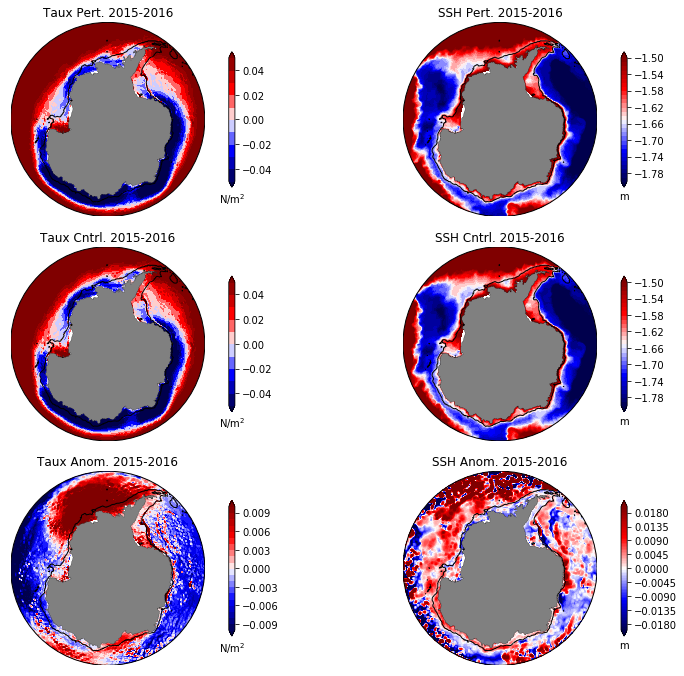

In [56]:
print tx_pert.shape

plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
yrs=np.arange(1968,2018,1)

yr = nonzero(yrs == 2015)[0][0]
print yrs[yr]
print yr

clev = np.arange(-.05,.051,.01)

plt.subplot(3,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,tx_pert[yr:yr+1,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('N/m$^2$')
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title('Taux Pert. '+yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

plt.subplot(3,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,tx_cntrl[yr:yr+1,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('N/m$^2$')
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title('Taux Cntrl. '+yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

clev = np.arange(-.01,0.011,.001)
plt.subplot(3,2,5)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,tx_pert[yr:yr+1,:,:].mean(axis=0)-tx_cntrl[yr:yr+1,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('N/m$^2$')
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title('Taux Anom. '+yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))


clev = np.arange(-1.8,-1.5,.01)

plt.subplot(3,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,ssh_pert[yr:yr+1,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('m')
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title('SSH Pert. '+yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

plt.subplot(3,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,ssh_cntrl[yr:yr+1,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('m')
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title('SSH Cntrl. '+yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

clev = np.arange(-0.02,0.0205,.0005)
plt.subplot(3,2,6)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,ssh_pert[yr:yr+1,:,:].mean(axis=0)-ssh_cntrl[yr:yr+1,:,:].mean(axis=0), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('m')
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title('SSH Anom. '+yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

#ax3 = plt.axes([0.95,0.38,0.015,0.25])
#cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
#cb.ax.set_xlabel('$^\circ$C')

plt.tight_layout()

In [57]:
msk=np.ones((tx_pert.shape[1],tx_pert.shape[2]))
msk[np.where(ht[0:250,:]>1000)]=0
msk[np.where(ht[0:250,:]<0)]=0

print np.nansum(area_t)
print st_ocean[st]

i1=821
i2=872
wap_tx_pert=np.zeros((50,1))
wap_ssh_pert=np.zeros((50,1))
for yr in range(0,50):
    #print yrs[yr]
    wap_tx_pert[yr]=np.nansum(tx_pert[yr,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    wap_ssh_pert[yr]=np.nansum(ssh_pert[yr,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    tarea=np.sum(area_t[0:250,i1:i2]*msk[:,i1:i2])
    #print tarea
    wap_tx_pert[yr]=wap_tx_pert[yr]/tarea
    wap_ssh_pert[yr]=wap_ssh_pert[yr]/tarea

print tarea
#print wap_tx_pert

i1=716
i2=820
bs_tx_pert=np.zeros((50,1))
bs_ssh_pert=np.zeros((50,1))
for yr in range(0,50):
    #print yrs[yr]
    bs_tx_pert[yr]=np.nansum(tx_pert[yr,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    bs_ssh_pert[yr]=np.nansum(ssh_pert[yr,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    tarea=np.sum(area_t[0:250,i1:i2]*msk[:,i1:i2])
    #print tarea
    bs_tx_pert[yr]=bs_tx_pert[yr]/tarea
    bs_ssh_pert[yr]=bs_ssh_pert[yr]/tarea

print tarea
#print bs_tx_pert

i1=613
i2=714
as_tx_pert=np.zeros((50,1))
as_ssh_pert=np.zeros((50,1))
for yr in range(0,50):
    #print yrs[yr]
    as_tx_pert[yr]=np.nansum(tx_pert[yr,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    as_ssh_pert[yr]=np.nansum(ssh_pert[yr,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    tarea=np.sum(area_t[0:250,i1:i2]*msk[:,i1:i2])
    #print tarea
    as_tx_pert[yr]=as_tx_pert[yr]/tarea
    as_ssh_pert[yr]=as_ssh_pert[yr]/tarea

print tarea
#print as_tx_pert


5.07057e+14
201.262954712
366844120624.0
293159054104.0
176677553624.0


In [58]:

msk=np.ones((tx_cntrl.shape[1],tx_cntrl.shape[2]))
msk[np.where(ht[0:250,:]>1000)]=0
msk[np.where(ht[0:250,:]<0)]=0

print np.nansum(area_t)
print st_ocean[st]

i1=821
i2=872
wap_tx_cntrl=np.zeros((50,1))
wap_ssh_cntrl=np.zeros((50,1))
for yr in range(0,50):
    #print yrs[yr]
    wap_tx_cntrl[yr]=np.nansum(tx_cntrl[yr,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    wap_ssh_cntrl[yr]=np.nansum(ssh_cntrl[yr,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    tarea=np.sum(area_t[0:250,i1:i2]*msk[:,i1:i2])
    #print tarea
    wap_tx_cntrl[yr]=wap_tx_cntrl[yr]/tarea
    wap_ssh_cntrl[yr]=wap_ssh_cntrl[yr]/tarea

print tarea
#print wap_tx_cntrl

i1=716
i2=820
bs_tx_cntrl=np.zeros((50,1))
bs_ssh_cntrl=np.zeros((50,1))
for yr in range(0,50):
    #print yrs[yr]
    bs_tx_cntrl[yr]=np.nansum(tx_cntrl[yr,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    bs_ssh_cntrl[yr]=np.nansum(ssh_cntrl[yr,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    tarea=np.sum(area_t[0:250,i1:i2]*msk[:,i1:i2])
    #print tarea
    bs_tx_cntrl[yr]=bs_tx_cntrl[yr]/tarea
    bs_ssh_cntrl[yr]=bs_ssh_cntrl[yr]/tarea

print tarea
#print bs_tx_cntrl

i1=613
i2=714
as_tx_cntrl=np.zeros((50,1))
as_ssh_cntrl=np.zeros((50,1))
for yr in range(0,50):
    #print yrs[yr]
    as_tx_cntrl[yr]=np.nansum(tx_cntrl[yr,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    as_ssh_cntrl[yr]=np.nansum(ssh_cntrl[yr,:,i1:i2]*area_t[0:250,i1:i2]*msk[:,i1:i2])
    tarea=np.sum(area_t[0:250,i1:i2]*msk[:,i1:i2])
    #print tarea
    as_tx_cntrl[yr]=as_tx_cntrl[yr]/tarea
    as_ssh_cntrl[yr]=as_ssh_cntrl[yr]/tarea

print tarea
#print as_tx_cntrl


5.07057e+14
201.262954712
366844120624.0
293159054104.0
176677553624.0


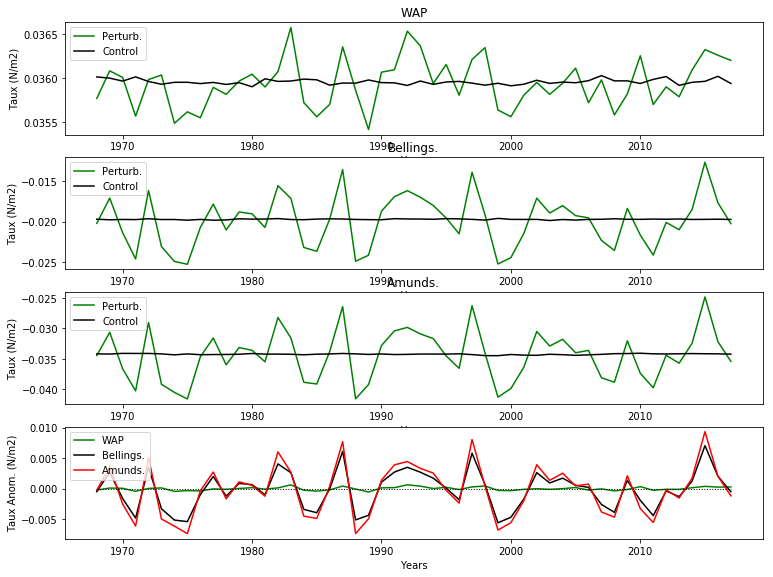

In [59]:
plt.subplot(411)
plt.plot(yrs,wap_tx_pert,linestyle='-',color='g',label='Perturb.',linewidth=1.5)
plt.plot(yrs,wap_tx_cntrl,linestyle='-',color='k',label='Control',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Taux (N/m2)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('WAP')
plt.legend(fontsize=10)

plt.subplot(412)
plt.plot(yrs,bs_tx_pert,linestyle='-',color='g',label='Perturb.',linewidth=1.5)
plt.plot(yrs,bs_tx_cntrl,linestyle='-',color='k',label='Control',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Taux (N/m2)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('Bellings.')
plt.legend(fontsize=10)

plt.subplot(413)
plt.plot(yrs,as_tx_pert,linestyle='-',color='g',label='Perturb.',linewidth=1.5)
plt.plot(yrs,as_tx_cntrl,linestyle='-',color='k',label='Control',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Taux (N/m2)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('Amunds.')
plt.legend(fontsize=10)

plt.subplot(414)
plt.plot(yrs,wap_tx_pert-wap_tx_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
plt.plot(yrs,bs_tx_pert-bs_tx_cntrl,linestyle='-',color='k',label='Bellings.',linewidth=1.5)
plt.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Amunds.',linewidth=1.5)
plt.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
plt.ylabel('Taux Anom. (N/m2)')
plt.xlabel('Years')
#plt.xlim([-75,85])
#plt.title('AMOC Rho Space')
plt.legend(fontsize=10)

of = os.path.join(NYFPertDir,'taux_ENSO_ts_anom.png')
plt.savefig(of,dpi=220)

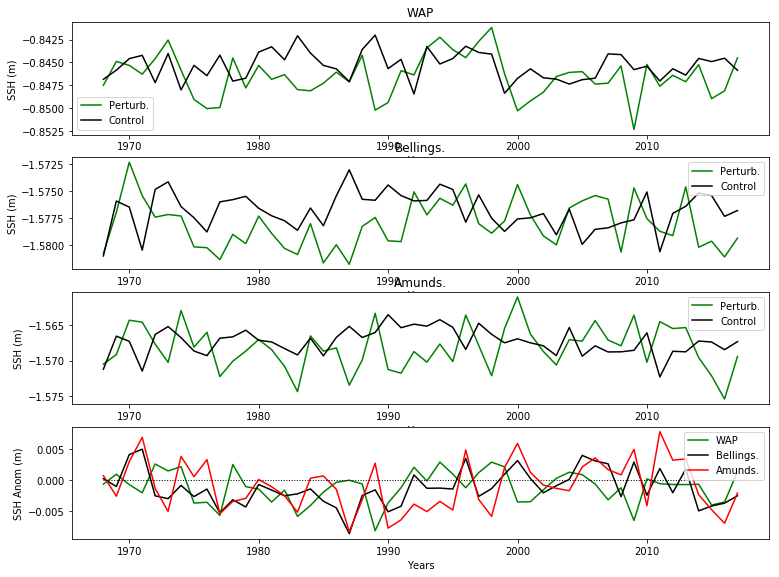

In [60]:
#do ssh 
plt.subplot(411)
plt.plot(yrs,wap_ssh_pert,linestyle='-',color='g',label='Perturb.',linewidth=1.5)
plt.plot(yrs,wap_ssh_cntrl,linestyle='-',color='k',label='Control',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('SSH (m)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('WAP')
plt.legend(fontsize=10)

plt.subplot(412)
plt.plot(yrs,bs_ssh_pert,linestyle='-',color='g',label='Perturb.',linewidth=1.5)
plt.plot(yrs,bs_ssh_cntrl,linestyle='-',color='k',label='Control',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('SSH (m)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('Bellings.')
plt.legend(fontsize=10)

plt.subplot(413)
plt.plot(yrs,as_ssh_pert,linestyle='-',color='g',label='Perturb.',linewidth=1.5)
plt.plot(yrs,as_ssh_cntrl,linestyle='-',color='k',label='Control',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('SSH (m)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('Amunds.')
plt.legend(fontsize=10)

plt.subplot(414)
plt.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
plt.plot(yrs,bs_ssh_pert-bs_ssh_cntrl,linestyle='-',color='k',label='Bellings.',linewidth=1.5)
plt.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='-',color='r',label='Amunds.',linewidth=1.5)
plt.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
plt.ylabel('SSH Anom (m)')
plt.xlabel('Years')
#plt.xlim([-75,85])
#plt.title('AMOC Rho Space')
plt.legend(fontsize=10)

of = os.path.join(NYFPertDir,'ssh_ENSO_ts_anom.png')
plt.savefig(of,dpi=220)

In [30]:
def align_yaxis_np(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = np.array([ax1, ax2])
    extrema = np.array([ax.get_ylim() for ax in axes])
    tops = extrema[:,1] / (extrema[:,1] - extrema[:,0])
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [a[::-1] for a in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    extrema[0,1] = extrema[0,0] + tot_span * (extrema[0,1] - extrema[0,0])
    extrema[1,0] = extrema[1,1] + tot_span * (extrema[1,0] - extrema[1,1])
    [axes[i].set_ylim(*extrema[i]) for i in range(2)]

(1788, 1)
1175
(1980, 1)
1367


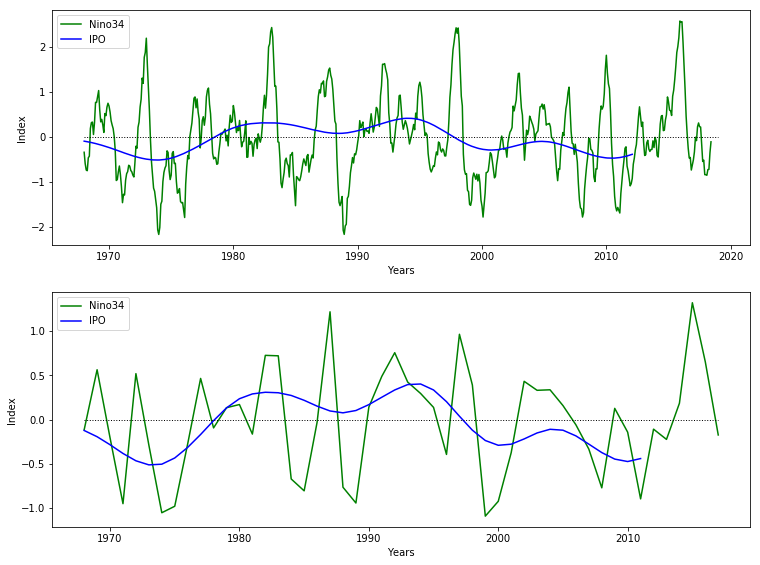

In [31]:
#n34yr = year
#n34mn = month
#n34yrd = year + month/12
#it's 1870-2018
hadsst = sp.io.loadmat('/g/data1a/v45/pas561/mom/archive/gfdl_nyf_iafAntSOI/HadISST_Nino3p4.mat')#,'bat_lat')
hadsst_n34yr=hadsst['n34yr']
hadsst_n34yrd=hadsst['n34yrd']
hadsst_n34=hadsst['n34']
print hadsst_n34yrd.shape
hadsst_yri = nonzero(hadsst_n34yrd == 1968)[0][0]
print hadsst_yri

#print ERSST_ipo[ERSST_yri:ERSST_yri+12]
hadsst_n34_ann=np.zeros((50,1))
i=hadsst_yri
for t in range(50):
        #print hadsst_yri
        hadsst_n34_ann[t]=np.mean(hadsst_n34[i:i+12])
        i=i+12


#ipo = time series
#ipoyr = year
#ipomn = month
#ipoyrd = year + month/12 (edited)
ERSST= sp.io.loadmat('/g/data1a/v45/pas561/mom/archive/gfdl_nyf_iafAntSOI/TPI_ERSSTV5_IPOindex.mat')
ERSST_ipo=ERSST['ipo']
ERSST_ipoyrd=ERSST['ipoyrd']
ERSST_ipoyr=ERSST['ipoyr']
print ERSST_ipo.shape
ERSST_yri = nonzero(ERSST_ipoyrd == 1968)[0][0]
print ERSST_yri

#print ERSST_ipo[ERSST_yri:ERSST_yri+12]
ERSST_ipo_ann=np.zeros((50,1))
i=ERSST_yri
for t in range(50):
        #print ERSST_yri
        ERSST_ipo_ann[t]=np.mean(ERSST_ipo[i:i+12])
        i=i+12

plt.subplot(211)
plt.plot(hadsst_n34yrd[hadsst_yri:],hadsst_n34[hadsst_yri:],linestyle='-',color='g',label='Nino34',linewidth=1.5)
plt.plot(ERSST_ipoyrd[ERSST_yri:],ERSST_ipo[ERSST_yri:],linestyle='-',color='b',label='IPO',linewidth=1.5)
plt.plot(ERSST_ipoyrd[ERSST_yri:],np.zeros((ERSST_ipoyrd[ERSST_yri:].shape)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
plt.ylabel('Index')
plt.xlabel('Years')
#plt.xlim([-75,85])
#plt.title('Nino34')
plt.legend(fontsize=10)

plt.subplot(212)
plt.plot(yrs,hadsst_n34_ann,linestyle='-',color='g',label='Nino34',linewidth=1.5)
plt.plot(yrs,ERSST_ipo_ann,linestyle='-',color='b',label='IPO',linewidth=1.5)
plt.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
plt.ylabel('Index')
plt.xlabel('Years')
#plt.xlim([-75,85])
#plt.title('Nino34')
plt.legend(fontsize=10)


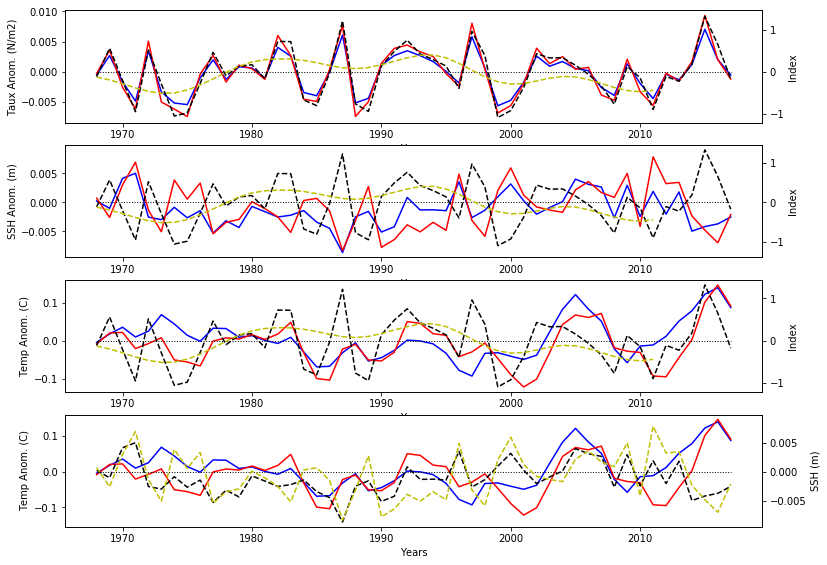

In [32]:
fig=figure()
ax1=plt.subplot(411)
#ax1.plot(yrs,wap_tx_pert-wap_tx_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs,bs_tx_pert-bs_tx_cntrl,linestyle='-',color='b',label='Bellings.',linewidth=1.5)
ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Taux Anom. (N/m2)')
ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs,hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
ax2.plot(yrs,ERSST_ipo_ann,linestyle='--',color='y',label='IPO',linewidth=1.5)
ax2.set_ylabel('Index')
ax2.set_xlabel('Years')
align_yaxis_np(ax1,ax2)
#ax2.legend(fontsize=10)
#plt.xlim([-75,85])
#plt.title('AMOC Rho Space')

ax1=plt.subplot(412)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs,bs_ssh_pert-bs_ssh_cntrl,linestyle='-',color='b',label='Bellings.',linewidth=1.5)
ax1.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='-',color='r',label='Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('SSH Anom. (m)')
ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs,hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
ax2.plot(yrs,ERSST_ipo_ann,linestyle='--',color='y',label='IPO',linewidth=1.5)
ax2.set_ylabel('Index')
ax2.set_xlabel('Years')
align_yaxis_np(ax1,ax2)
#ax2.legend(fontsize=10)
#plt.xlim([-75,85])
#plt.title('AMOC Rho Space')

ax1=plt.subplot(413)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs,bs_tpert-bs_tcntrl,linestyle='-',color='b',label='Bellings.',linewidth=1.5)
ax1.plot(yrs,as_tpert-as_tcntrl,linestyle='-',color='r',label='Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom. (C)')
ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs,hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
ax2.plot(yrs,ERSST_ipo_ann,linestyle='--',color='y',label='IPO',linewidth=1.5)
ax2.set_ylabel('Index')
ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

ax1=plt.subplot(414)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs,bs_tpert-bs_tcntrl,linestyle='-',color='b',label='Bellings.',linewidth=1.5)
ax1.plot(yrs,as_tpert-as_tcntrl,linestyle='-',color='r',label='Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom. (C)')
ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs,bs_ssh_pert-bs_ssh_cntrl,linestyle='--',color='k',label='Bellings.',linewidth=1.5)
ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='Amunds.',linewidth=1.5)
ax2.set_ylabel('SSH (m)')
ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

#fig.tight_layout()

(50, 1) (50, 1)
R$^2$=0.00, P=0.73
(50, 1) (50, 1)
R$^2$=0.16, P=0.00
(50, 1) (50, 1)
R$^2$=0.03, P=0.25


Text(1970,0.09,u'R$^2$=0.03, P=0.25')

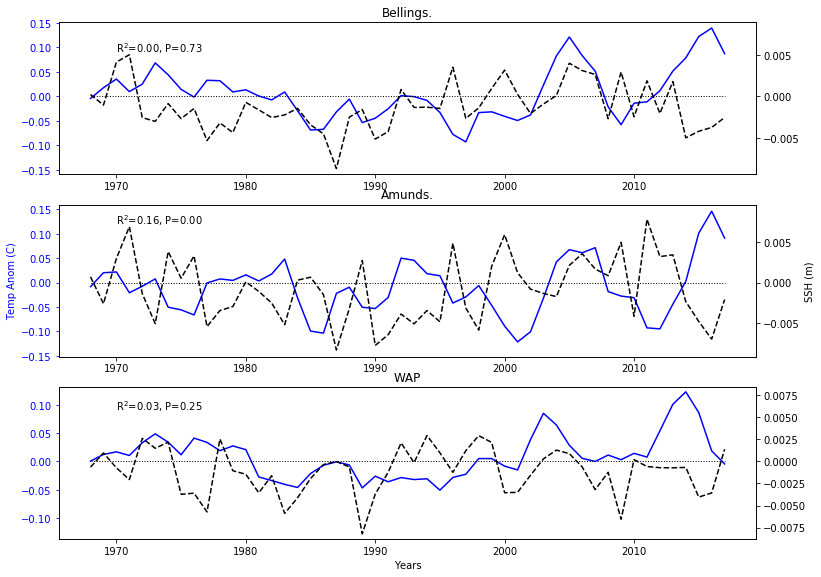

In [33]:
ax1=plt.subplot(311)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs,bs_tpert-bs_tcntrl,linestyle='-',color='b',label='Temp. Bellings.',linewidth=1.5)
#ax1.plot(yrs,as_tpert-as_tcntrl,linestyle='-',color='r',label='Temp. Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
#plt.ylim((1037.5,1035))
#ax1.set_ylabel('Temp Anom. (C)')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)
plt.title('Bellings.')

ax2=ax1.twinx()
ax2.plot(yrs,bs_ssh_pert-bs_ssh_cntrl,linestyle='--',color='k',label='SSH Bellings.',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
ax2.tick_params('y', colors='k')
align_yaxis_np(ax1,ax2)

a=bs_tpert-bs_tcntrl
b=bs_ssh_pert-bs_ssh_cntrl
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
#print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)


ax1=plt.subplot(312)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
#ax1.plot(yrs,bs_tpert-bs_tcntrl,linestyle='-',color='b',label='Temp. Bellings.',linewidth=1.5)
ax1.plot(yrs,as_tpert-as_tcntrl,linestyle='-',color='b',label='Temp. Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)
plt.title('Amunds.')

ax2=ax1.twinx()
#ax2.plot(yrs,bs_ssh_pert-bs_ssh_cntrl,linestyle='--',color='k',label='SSH Bellings.',linewidth=1.5)
ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='k',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('SSH (m)', color='k')
#ax2.set_xlabel('Years')
ax2.tick_params('y', colors='k')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=as_tpert-as_tcntrl
b=as_ssh_pert-as_ssh_cntrl
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
#print c
corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.12,corstr)

ax1=plt.subplot(313)
ax1.plot(yrs,wap_tpert-wap_tcntrl,linestyle='-',color='b',label='WAP',linewidth=1.5)
#ax1.plot(yrs,bs_tpert-bs_tcntrl,linestyle='-',color='b',label='Temp. Bellings.',linewidth=1.5)
#ax1.plot(yrs,as_tpert-as_tcntrl,linestyle='-',color='r',label='Temp. Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
#ax1.set_ylabel('Temp Anom. (C)')
ax1.tick_params('y', colors='b')
plt.title('WAP')
ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
#ax2.plot(yrs,bs_ssh_pert-bs_ssh_cntrl,linestyle='--',color='k',label='SSH Bellings.',linewidth=1.5)
ax2.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='--',color='k',label='SSH WAP',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
ax2.tick_params('y', colors='k')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=wap_tpert-wap_tcntrl
b=wap_ssh_pert-wap_ssh_cntrl
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
#print c
corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)


(50, 1) (50, 1)
R$^2$=0.15, P=0.00
(50, 1) (50, 1)
R$^2$=0.30, P=0.00
(50, 1) (50, 1)
R$^2$=0.06, P=0.08


Text(1970,0.0005,u'R$^2$=0.06, P=0.08')

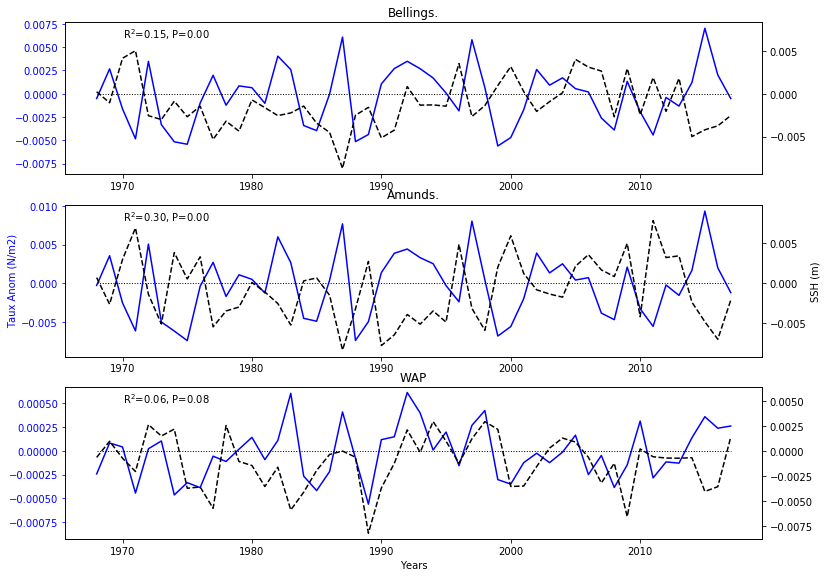

In [34]:
ax1=plt.subplot(311)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs,bs_tx_pert-bs_tx_cntrl,linestyle='-',color='b',label='Temp. Bellings.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Temp. Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
#plt.ylim((1037.5,1035))
#ax1.set_ylabel('Temp Anom. (C)')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)
plt.title('Bellings.')

ax2=ax1.twinx()
ax2.plot(yrs,bs_ssh_pert-bs_ssh_cntrl,linestyle='--',color='k',label='SSH Bellings.',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
ax2.tick_params('y', colors='k')
align_yaxis_np(ax1,ax2)

a=bs_tx_pert-bs_tx_cntrl
b=bs_ssh_pert-bs_ssh_cntrl
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
#print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.006,corstr)


ax1=plt.subplot(312)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
#ax1.plot(yrs,bs_tx_pert-bs_tx_cntrl,linestyle='-',color='b',label='Temp. Bellings.',linewidth=1.5)
ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='b',label='Temp. Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Taux Anom (N/m2)',color='b')
ax1.tick_params('y', colors='b')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)
plt.title('Amunds.')

ax2=ax1.twinx()
#ax2.plot(yrs,bs_ssh_pert-bs_ssh_cntrl,linestyle='--',color='k',label='SSH Bellings.',linewidth=1.5)
ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='k',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('SSH (m)', color='k')
#ax2.set_xlabel('Years')
ax2.tick_params('y', colors='k')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=as_tx_pert-as_tx_cntrl
b=as_ssh_pert-as_ssh_cntrl
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
#print c
corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.008,corstr)

ax1=plt.subplot(313)
ax1.plot(yrs,wap_tx_pert-wap_tx_cntrl,linestyle='-',color='b',label='WAP',linewidth=1.5)
#ax1.plot(yrs,bs_tx_pert-bs_tx_cntrl,linestyle='-',color='b',label='Temp. Bellings.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Temp. Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
#ax1.set_ylabel('Temp Anom. (C)')
ax1.tick_params('y', colors='b')
plt.title('WAP')
ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
#ax2.plot(yrs,bs_ssh_pert-bs_ssh_cntrl,linestyle='--',color='k',label='SSH Bellings.',linewidth=1.5)
ax2.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='--',color='k',label='SSH WAP',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
ax2.tick_params('y', colors='k')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=wap_tx_pert-wap_tx_cntrl
b=wap_ssh_pert-wap_ssh_cntrl
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
#print c
corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.0005,corstr)


(50, 1) (50, 1)
LinregressResult(slope=5.052922605600493, intercept=0.028920723596010178, rvalue=0.47398591572599741, pvalue=0.00050690950078140088, stderr=1.3548834687133251)
R$^2$=0.22, P=0.00
(50, 1) (50, 1)
LinregressResult(slope=139.99856415761221, intercept=0.010179321278060986, rvalue=0.96194199794464041, pvalue=1.0724625588315067e-28, stderr=5.7401091559227222)
R$^2$=0.93, P=0.00
(50, 1) (50, 1)
LinregressResult(slope=-103.22274869469328, intercept=-0.11403577343687361, rvalue=-0.67977362297130794, pvalue=5.6764984792575128e-08, stderr=16.07475719554801)
R$^2$=0.46, P=0.00


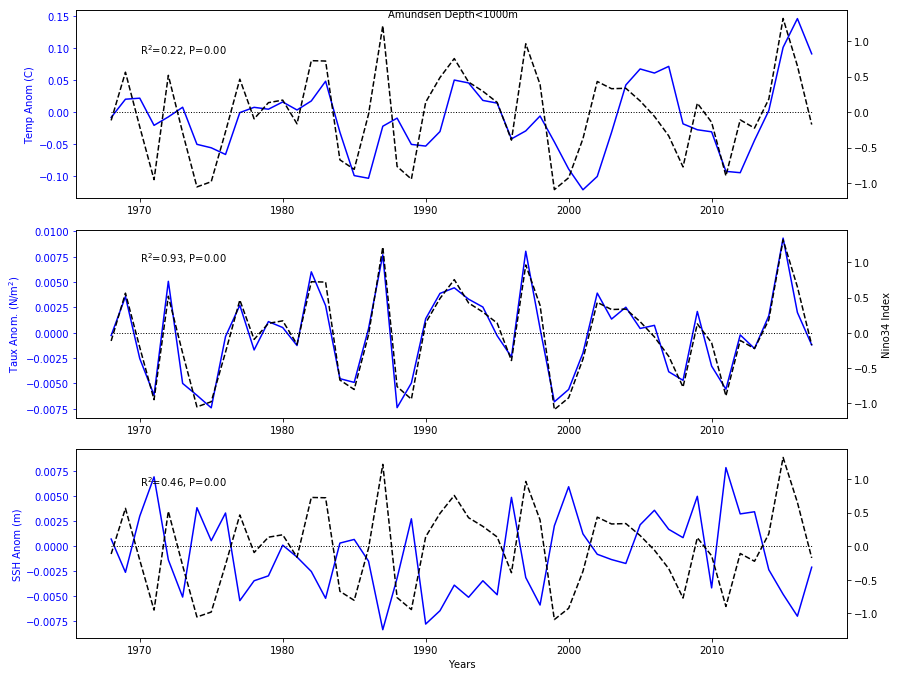

In [35]:
plt.suptitle('Amundsen Depth<1000m', fontsize=10)

ax1=plt.subplot(311)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs,as_tpert-as_tcntrl,linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs,hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=as_tpert-as_tcntrl
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)


ax1=plt.subplot(312)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
#ax1.plot(yrs,bs_tx_pert-bs_tx_cntrl,linestyle='-',color='b',label='Taux. Bellings.',linewidth=1.5)
ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='b',label='Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Taux Anom. (N/m$^2$)',color='b')
ax1.tick_params('y', colors='b')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
#ax2.plot(yrs,bs_ssh_pert-bs_ssh_cntrl,linestyle='--',color='k',label='SSH Bellings.',linewidth=1.5)
ax2.plot(yrs,hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
ax2.set_ylabel('Nino34 Index')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=as_tx_pert-as_tx_cntrl
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c
corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.007,corstr)

ax1=plt.subplot(313)
ax1.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,bs_tx_pert-bs_tx_cntrl,linestyle='-',color='b',label='Taux. Bellings.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('SSH Anom (m)',color='b')
ax1.tick_params('y', colors='b')
ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
#ax2.plot(yrs,bs_ssh_pert-bs_ssh_cntrl,linestyle='--',color='k',label='SSH Bellings.',linewidth=1.5)
ax2.plot(yrs,hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=as_ssh_pert-as_ssh_cntrl
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c
corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.006,corstr)

plt.tight_layout()

of = os.path.join(NYFPertDir,'AS_NIN34_ts.png')
plt.savefig(of,dpi=220)

(50, 1) (50, 1)
LinregressResult(slope=2.3103161890205386, intercept=-0.038721965505172547, rvalue=0.20111154772079906, pvalue=0.16137542173085032, stderr=1.6242337758036807)
R$^2$=0.04, P=0.16
(50, 1) (50, 1)
LinregressResult(slope=187.72410300661022, intercept=0.021106553002349229, rvalue=0.98198911392095412, pvalue=2.1374810058024633e-36, stderr=5.2132784007219373)
R$^2$=0.96, P=0.00
(50, 1) (50, 1)
LinregressResult(slope=-86.821665549975634, intercept=-0.13212305207014349, rvalue=-0.40889901891274905, pvalue=0.0031952767483446123, stderr=27.968050756954899)
R$^2$=0.17, P=0.00


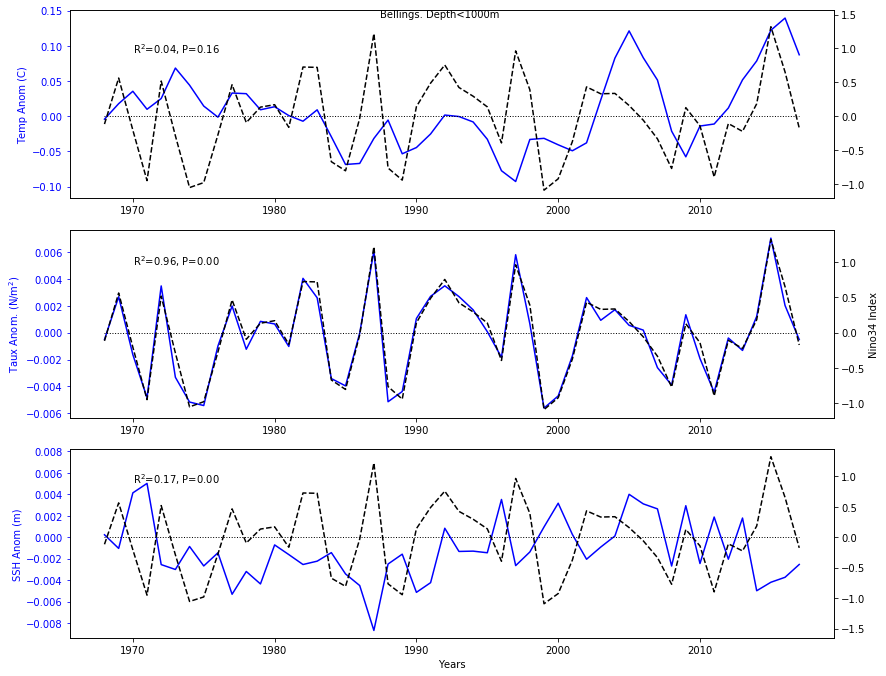

In [36]:
plt.suptitle('Bellings. Depth<1000m', fontsize=10)

ax1=plt.subplot(311)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs,bs_tpert-bs_tcntrl,linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,bs_tx_pert-bs_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs,hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,bs_ssh_pert-bs_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=bs_tpert-bs_tcntrl
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)


ax1=plt.subplot(312)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
#ax1.plot(yrs,bs_tx_pert-bs_tx_cntrl,linestyle='-',color='b',label='Taux. Bellings.',linewidth=1.5)
ax1.plot(yrs,bs_tx_pert-bs_tx_cntrl,linestyle='-',color='b',label='Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Taux Anom. (N/m$^2$)',color='b')
ax1.tick_params('y', colors='b')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
#ax2.plot(yrs,bs_ssh_pert-bs_ssh_cntrl,linestyle='--',color='k',label='SSH Bellings.',linewidth=1.5)
ax2.plot(yrs,hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
ax2.set_ylabel('Nino34 Index')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=bs_tx_pert-bs_tx_cntrl
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c
corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.005,corstr)

ax1=plt.subplot(313)
ax1.plot(yrs,bs_ssh_pert-bs_ssh_cntrl,linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,bs_tx_pert-bs_tx_cntrl,linestyle='-',color='b',label='Taux. Bellings.',linewidth=1.5)
#ax1.plot(yrs,bs_tx_pert-bs_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('SSH Anom (m)',color='b')
ax1.tick_params('y', colors='b')
ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
#ax2.plot(yrs,bs_ssh_pert-bs_ssh_cntrl,linestyle='--',color='k',label='SSH Bellings.',linewidth=1.5)
ax2.plot(yrs,hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=bs_ssh_pert-bs_ssh_cntrl
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c
corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.005,corstr)

plt.tight_layout()
of = os.path.join(NYFPertDir,'BS_NIN34_ts.png')
plt.savefig(of,dpi=220)

(50, 1) (50, 1)
LinregressResult(slope=1.6165380082750005, intercept=-0.038284874279914109, rvalue=0.10302202107755218, pvalue=0.47649684120738356, stderr=2.2527770752512248)
R$^2$=0.01, P=0.48
(50, 1) (50, 1)
LinregressResult(slope=1725.4674185932213, intercept=0.0084824989608761787, rvalue=0.7969366035974953, pvalue=4.4128509265460129e-12, stderr=188.77503975057235)
R$^2$=0.64, P=0.00
(50, 1) (50, 1)
LinregressResult(slope=28.785622885493463, intercept=0.0084666813228050329, rvalue=0.12285044131062828, pvalue=0.39535931921770562, stderr=33.564182474269877)
R$^2$=0.02, P=0.40


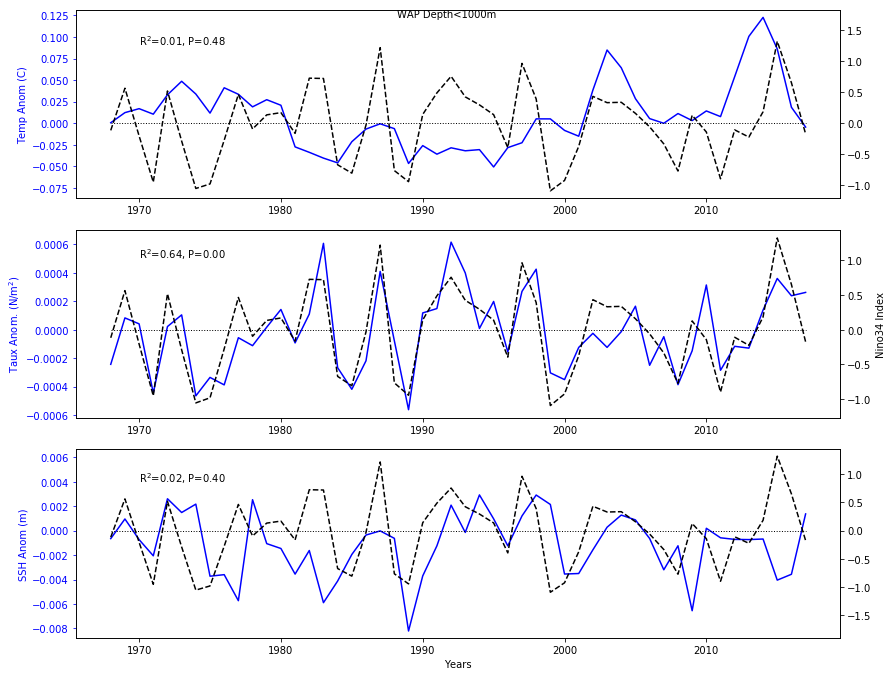

In [37]:
plt.suptitle('WAP Depth<1000m', fontsize=10)

ax1=plt.subplot(311)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs,wap_tpert-wap_tcntrl,linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,wap_tx_pert-wap_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs,hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=wap_tpert-wap_tcntrl
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)


ax1=plt.subplot(312)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
#ax1.plot(yrs,wap_tx_pert-wap_tx_cntrl,linestyle='-',color='b',label='Taux. Bellings.',linewidth=1.5)
ax1.plot(yrs,wap_tx_pert-wap_tx_cntrl,linestyle='-',color='b',label='Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Taux Anom. (N/m$^2$)',color='b')
ax1.tick_params('y', colors='b')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
#ax2.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='--',color='k',label='SSH Bellings.',linewidth=1.5)
ax2.plot(yrs,hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
ax2.set_ylabel('Nino34 Index')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=wap_tx_pert-wap_tx_cntrl
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c
corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.0005,corstr)

ax1=plt.subplot(313)
ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,wap_tx_pert-wap_tx_cntrl,linestyle='-',color='b',label='Taux. Bellings.',linewidth=1.5)
#ax1.plot(yrs,wap_tx_pert-wap_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('SSH Anom (m)',color='b')
ax1.tick_params('y', colors='b')
ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
#ax2.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='--',color='k',label='SSH Bellings.',linewidth=1.5)
ax2.plot(yrs,hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=wap_ssh_pert-wap_ssh_cntrl
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c
corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.004,corstr)

plt.tight_layout()

of = os.path.join(NYFPertDir,'WAP_NIN34_ts.png')
plt.savefig(of,dpi=220)

In [38]:
import pandas as pd
#a = np.arange(20)
#print a
#b=pd.rolling_mean(a, window=3, center=True)
#print b

hadsst_n34_ann_5yr = pd.rolling_mean(hadsst_n34_ann, window=5, center=True)
print hadsst_n34_ann_5yr.shape

as_tpert_anom_5yr=pd.rolling_mean(as_tpert-as_tcntrl, window=5, center=True)
print as_tpert_anom_5yr[2:-2,0]

(50, 1)
[ 0.00116311  0.00435291 -0.00977292 -0.02530608 -0.03442159 -0.03307038
 -0.03309683 -0.02210254 -0.00775261  0.00617702  0.00982157  0.0179879
  0.01079902 -0.01225582 -0.03364031 -0.04155744 -0.05310624 -0.05693405
 -0.04769442 -0.03306589 -0.0186054  -0.00759159  0.00617952  0.01962554
  0.01733365  0.00141589 -0.00893793 -0.02193584 -0.04257223 -0.05850669
 -0.07277012 -0.07789178 -0.06006618 -0.02872799  0.00781486  0.0422759
  0.04494796  0.03093716  0.01125409 -0.01952276 -0.0528085  -0.05797627
 -0.05196554 -0.0255261   0.02229714  0.05951242]


/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


(50, 1)


/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/ipykernel/__main__.py:47: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/ipykernel/__main__.py:79: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


(50, 1) (50, 1)
LinregressResult(slope=4.5804765998134362, intercept=0.030036615722066978, rvalue=0.5789529305434129, pvalue=2.4968674101570705e-05, stderr=0.97250309082910058)
R$^2$=0.34, P=0.00
(50, 1) (50, 1)
LinregressResult(slope=0.49927952159473721, intercept=-0.044029752396442932, rvalue=0.074796928940906629, pvalue=0.6212854555186289, stderr=1.0034954085904788)
R$^2$=0.01, P=0.62
(50, 1) (50, 1)
LinregressResult(slope=-1.7446058776191933, intercept=-0.02950397812329595, rvalue=-0.21312090791734775, pvalue=0.15500484499744374, stderr=1.2057325416264197)
R$^2$=0.05, P=0.16


Text(1970,0.05,u'R$^2$=0.05, P=0.16')

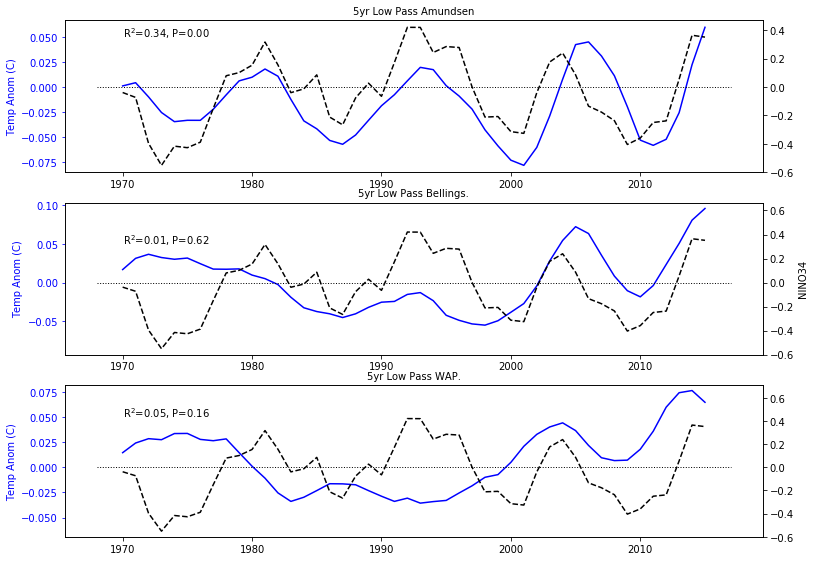

In [39]:
#do rolling centred mean of time-series

import pandas as pd
#a = np.arange(20)
#print a
#b=pd.rolling_mean(a, window=3, center=True)
#print b

hadsst_n34_ann_5yr = pd.rolling_mean(hadsst_n34_ann, window=5, center=True)
print hadsst_n34_ann_5yr.shape

as_tpert_anom_5yr=pd.rolling_mean(as_tpert-as_tcntrl, window=5, center=True)

#plt.suptitle('5yr Low Pass Amundsen', fontsize=10)

ax1=plt.subplot(311)
plt.title('5yr Low Pass Amundsen', fontsize=10)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs,as_tpert_anom_5yr,linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs,hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=as_tpert_anom_5yr
b=hadsst_n34_ann_5yr
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.05,corstr)


bs_tpert_anom_5yr=pd.rolling_mean(bs_tpert-bs_tcntrl, window=5, center=True)

ax1=plt.subplot(312)
plt.title('5yr Low Pass Bellings.', fontsize=10)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs,bs_tpert_anom_5yr,linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs,hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('NINO34')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=bs_tpert_anom_5yr
b=hadsst_n34_ann_5yr
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.05,corstr)

wap_tpert_anom_5yr=pd.rolling_mean(wap_tpert-wap_tcntrl, window=5, center=True)

ax1=plt.subplot(313)
plt.title('5yr Low Pass WAP.', fontsize=10)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs,wap_tpert_anom_5yr,linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs,hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=wap_tpert_anom_5yr
b=hadsst_n34_ann_5yr
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.05,corstr)


In [41]:
#now do sea ice ...



In [43]:
Ocean_File = os.path.join(NYFCntrlDir,'output*/ice_month.nc')
print Ocean_File
cntrli=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print cntrli.HI.shape


Ocean_File = os.path.join(NYFPertDir,'output*/ice_month.nc')
print Ocean_File
perti=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print perti.HI.shape

/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080_cp/output*/ice_month.nc
(600, 1080, 1440)
/g/data1/v45/pas561/mom/archive/gfdl_nyf_iafAntSOI/output*/ice_month.nc
(600, 1080, 1440)


In [47]:
#hi_anom_ann=np.zeros((50,250,1440))
#m=0
#for t in range(50):
#        #print hadsst_yri
#        hi_anom_ann[t,:,:]=perti.HI[m:m+12,0:250,:].mean('time').load()-cntrli.HI[m:m+12,0:250,:].mean('time').load()
#        m=m+12
#of=os.path.join(NYFPertDir,'hi_anom_ann.npy')
#a=np.save(of,hi_anom_ann)       

In [49]:
of=os.path.join(NYFPertDir,'hi_anom_ann.npy')
hi_anom_ann=np.load(of)
print hi_anom_ann.shape

(50, 250, 1440)


201.262954712
1972
4
1982
14
1997
29
2015
47


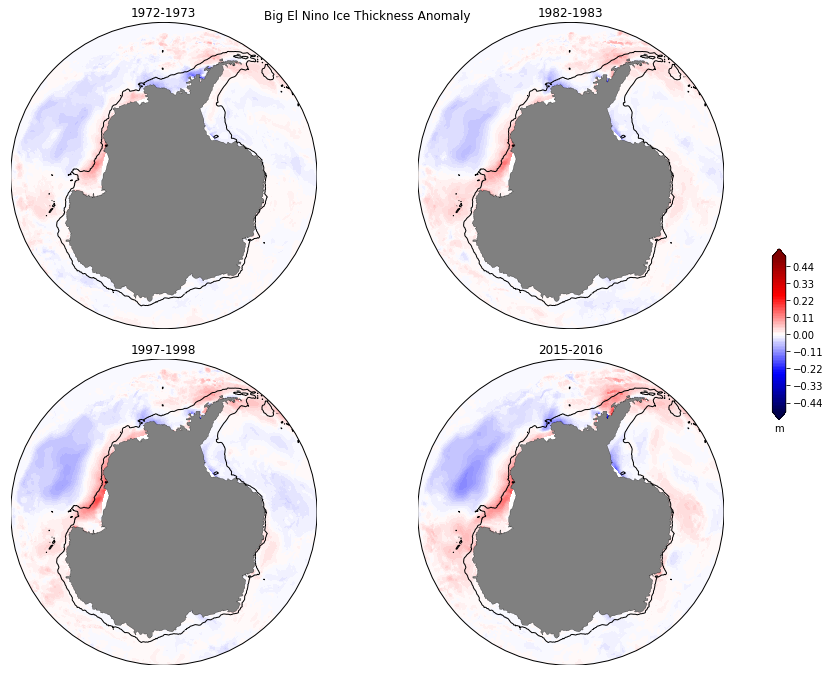

In [52]:
#plot HI anom
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Big El Nino Ice Thickness Anomaly')
clev = np.arange(-.5,0.51,.01)
yrs=np.arange(1968,2018,1)
print st_ocean[16]
st=16

yr = nonzero(yrs == 1972)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,hi_anom_ann[yr], cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1982)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,hi_anom_ann[yr], cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1997)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,hi_anom_ann[yr], cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2015)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,hi_anom_ann[yr], cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))


ax3 = plt.axes([0.95,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('m')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'HI_EN_anom.png')
plt.savefig(of,dpi=220)



201.262954712
1988
20
1999
31
2007
39
2010
42


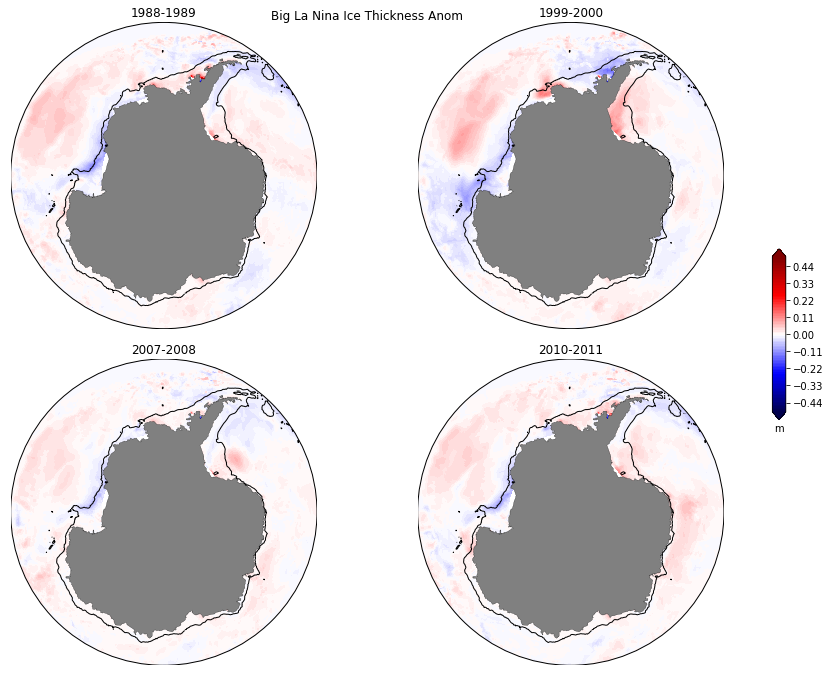

In [53]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Big La Nina Ice Thickness Anom')
clev = np.arange(-.5,0.51,.01)
yrs=np.arange(1968,2018,1)
print st_ocean[16]
st=16

yr = nonzero(yrs == 1988)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,hi_anom_ann[yr], cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1999)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,hi_anom_ann[yr], cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2007)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,hi_anom_ann[yr], cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2010)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,hi_anom_ann[yr], cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))


ax3 = plt.axes([0.95,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('m')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'HI_LN_anom.png')
plt.savefig(of,dpi=220)



In [63]:
#ice thickness time-series on shelf
print hi_anom_ann.shape[1]

250


In [67]:
#msk=np.ones((hi_anom_ann.shape[1],hi_anom_ann[2]))
msk=np.ones((250,1440))
msk[np.where(ht[0:250,:]>1000)]=0
msk[np.where(ht[0:250,:]<0)]=0

print np.nansum(area_t)
print st_ocean[st]

wi1=821
wi2=872
bi1=716
bi2=820
ai1=613
ai2=714

wap_hipert=np.zeros((600,1))
wap_hicntrl=np.zeros((600,1))
bs_hipert=np.zeros((600,1))
bs_hicntrl=np.zeros((600,1))
as_hipert=np.zeros((600,1))
as_hicntrl=np.zeros((600,1))
for mnth in range(0,600):
    print mnth
    wap_hipert[mnth]=np.nansum(perti.HI[mnth,0:250,wi1:wi2]*area_t[0:250,wi1:wi2]*msk[:,wi1:wi2])
    wap_hicntrl[mnth]=np.nansum(cntrli.HI[mnth,0:250,wi1:wi2]*area_t[0:250,wi1:wi2]*msk[:,wi1:wi2])
    warea=np.sum(area_t[0:250,wi1:wi2]*msk[:,wi1:wi2])
    wap_hipert[mnth]=wap_hipert[mnth]/warea
    wap_hicntrl[mnth]=wap_hicntrl[mnth]/warea
    
    bs_hipert[mnth]=np.nansum(perti.HI[mnth,0:250,bi1:bi2]*area_t[0:250,bi1:bi2]*msk[:,bi1:bi2])
    bs_hicntrl[mnth]=np.nansum(cntrli.HI[mnth,0:250,bi1:bi2]*area_t[0:250,bi1:bi2]*msk[:,bi1:bi2])
    barea=np.sum(area_t[0:250,bi1:bi2]*msk[:,bi1:bi2])
    bs_hipert[mnth]=bs_hipert[mnth]/barea
    bs_hicntrl[mnth]=bs_hicntrl[mnth]/barea
    
    as_hipert[mnth]=np.nansum(perti.HI[mnth,0:250,ai1:ai2]*area_t[0:250,ai1:ai2]*msk[:,ai1:ai2])
    as_hicntrl[mnth]=np.nansum(cntrli.HI[mnth,0:250,ai1:ai2]*area_t[0:250,ai1:ai2]*msk[:,ai1:ai2])
    aarea=np.sum(area_t[0:250,ai1:ai2]*msk[:,ai1:ai2])
    as_hipert[mnth]=as_hipert[mnth]/aarea
    as_hicntrl[mnth]=as_hicntrl[mnth]/aarea
    

5.07057e+14
201.262954712
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


In [72]:
print hadsst_n34yrd.shape
hadsst_yri = nonzero(hadsst_n34yrd == 1968)[0][0]
#print hadsst_yri
#print hadsst_n34yrd[hadsst_yri:hadsst_yri+600]

(1788, 1)
1175
[[ 1968.        ]
 [ 1968.08333333]
 [ 1968.16666667]
 [ 1968.25      ]
 [ 1968.33333333]
 [ 1968.41666667]
 [ 1968.5       ]
 [ 1968.58333333]
 [ 1968.66666667]
 [ 1968.75      ]
 [ 1968.83333333]
 [ 1968.91666667]
 [ 1969.        ]
 [ 1969.08333333]
 [ 1969.16666667]
 [ 1969.25      ]
 [ 1969.33333333]
 [ 1969.41666667]
 [ 1969.5       ]
 [ 1969.58333333]
 [ 1969.66666667]
 [ 1969.75      ]
 [ 1969.83333333]
 [ 1969.91666667]
 [ 1970.        ]
 [ 1970.08333333]
 [ 1970.16666667]
 [ 1970.25      ]
 [ 1970.33333333]
 [ 1970.41666667]
 [ 1970.5       ]
 [ 1970.58333333]
 [ 1970.66666667]
 [ 1970.75      ]
 [ 1970.83333333]
 [ 1970.91666667]
 [ 1971.        ]
 [ 1971.08333333]
 [ 1971.16666667]
 [ 1971.25      ]
 [ 1971.33333333]
 [ 1971.41666667]
 [ 1971.5       ]
 [ 1971.58333333]
 [ 1971.66666667]
 [ 1971.75      ]
 [ 1971.83333333]
 [ 1971.91666667]
 [ 1972.        ]
 [ 1972.08333333]
 [ 1972.16666667]
 [ 1972.25      ]
 [ 1972.33333333]
 [ 1972.41666667]
 [ 1972.5    

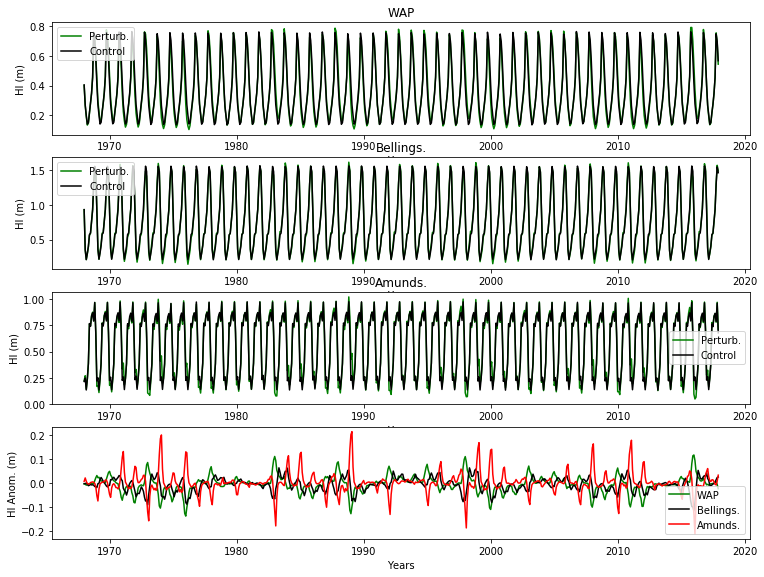

In [73]:
plt.subplot(411)
plt.plot(hadsst_n34yrd[hadsst_yri:hadsst_yri+600],wap_hipert,linestyle='-',color='g',label='Perturb.',linewidth=1.5)
plt.plot(hadsst_n34yrd[hadsst_yri:hadsst_yri+600],wap_hicntrl,linestyle='-',color='k',label='Control',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('HI (m)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('WAP')
plt.legend(fontsize=10)

plt.subplot(412)
plt.plot(hadsst_n34yrd[hadsst_yri:hadsst_yri+600],bs_hipert,linestyle='-',color='g',label='Perturb.',linewidth=1.5)
plt.plot(hadsst_n34yrd[hadsst_yri:hadsst_yri+600],bs_hicntrl,linestyle='-',color='k',label='Control',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('HI (m)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('Bellings.')
plt.legend(fontsize=10)

plt.subplot(413)
plt.plot(hadsst_n34yrd[hadsst_yri:hadsst_yri+600],as_hipert,linestyle='-',color='g',label='Perturb.',linewidth=1.5)
plt.plot(hadsst_n34yrd[hadsst_yri:hadsst_yri+600],as_hicntrl,linestyle='-',color='k',label='Control',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('HI (m)')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('Amunds.')
plt.legend(fontsize=10)

plt.subplot(414)
plt.plot(hadsst_n34yrd[hadsst_yri:hadsst_yri+600],wap_hipert-wap_hicntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
plt.plot(hadsst_n34yrd[hadsst_yri:hadsst_yri+600],bs_hipert-bs_hicntrl,linestyle='-',color='k',label='Bellings.',linewidth=1.5)
plt.plot(hadsst_n34yrd[hadsst_yri:hadsst_yri+600],as_hipert-as_hicntrl,linestyle='-',color='r',label='Amunds.',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('HI Anom. (m)')
plt.xlabel('Years')
#plt.xlim([-75,85])
#plt.title('AMOC Rho Space')
plt.legend(fontsize=10)

of = os.path.join(NYFPertDir,'HI_ENSO_ts_anom.png')
plt.savefig(of,dpi=220)

(600, 1) (600, 1)
LinregressResult(slope=-10.789703969604322, intercept=0.00089217407078759359, rvalue=-0.54410765334748801, pvalue=3.1391129820169022e-47, stderr=0.68265521257169826)
R$^2$=0.30, P=0.00
(600, 1) (600, 1)
LinregressResult(slope=-4.7218388670087865, intercept=-0.052631612635583296, rvalue=-0.1518842270672594, pvalue=0.00019781091557785496, stderr=1.2607740187142795)
R$^2$=0.02, P=0.00
(600, 1) (600, 1)
LinregressResult(slope=20.286332197769656, intercept=0.058240714431610205, rvalue=0.80241672780841311, pvalue=2.7343914162275887e-135, stderr=0.61903189781807377)
R$^2$=0.64, P=0.00


Text(1970,0.12,u'R$^2$=0.64, P=0.00')

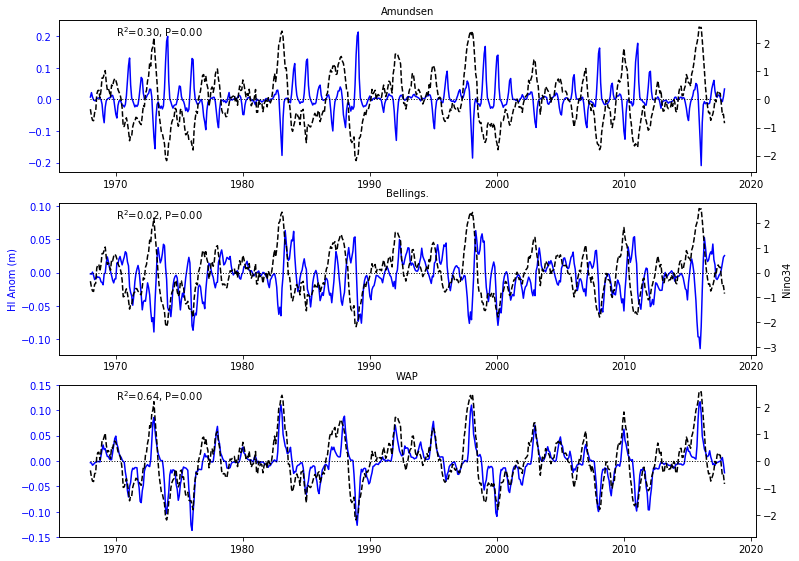

In [78]:
ax1=plt.subplot(311)
plt.title('Amundsen', fontsize=10)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(hadsst_n34yrd[hadsst_yri:hadsst_yri+600],as_hipert-as_hicntrl,linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
#ax1.set_ylabel('HI Anom (m)',color='b')
ax1.tick_params('y', colors='b')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(hadsst_n34yrd[hadsst_yri:hadsst_yri+600],hadsst_n34[hadsst_yri:hadsst_yri+600],linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=as_hipert-as_hicntrl
b=hadsst_n34[hadsst_yri:hadsst_yri+600]
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.2,corstr)

ax1=plt.subplot(312)
plt.title('Bellings.', fontsize=10)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(hadsst_n34yrd[hadsst_yri:hadsst_yri+600],bs_hipert-bs_hicntrl,linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('HI Anom (m)',color='b')
ax1.tick_params('y', colors='b')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(hadsst_n34yrd[hadsst_yri:hadsst_yri+600],hadsst_n34[hadsst_yri:hadsst_yri+600],linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=bs_hipert-bs_hicntrl
b=hadsst_n34[hadsst_yri:hadsst_yri+600]
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.08,corstr)

ax1=plt.subplot(313)
plt.title('WAP', fontsize=10)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(hadsst_n34yrd[hadsst_yri:hadsst_yri+600],wap_hipert-wap_hicntrl,linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs,np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
#ax1.set_ylabel('HI Anom (m)',color='b')
ax1.tick_params('y', colors='b')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(hadsst_n34yrd[hadsst_yri:hadsst_yri+600],hadsst_n34[hadsst_yri:hadsst_yri+600],linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=wap_hipert-wap_hicntrl
b=hadsst_n34[hadsst_yri:hadsst_yri+600]
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.12,corstr)


In [ ]:
#look at the access-om2 jra iaf run
#ocean.jra_iaf.temp.90to119.cat.diff90to119avg.nc
#/g/data3/hh5/tmp/pas561/access-om2-jra-iaf
#g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf

In [81]:
OM2_025_PertDir='/g/data3/hh5/tmp/pas561/access-om2-jra-iaf'
Ocean_File = os.path.join(OM2_025_PertDir,'ocean.jra_iaf.temp.90to119.cat.diff90to119avg.nc')
print Ocean_File
pert=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print pert.temp.shape

/g/data3/hh5/tmp/pas561/access-om2-jra-iaf/ocean.jra_iaf.temp.90to119.cat.diff90to119avg.nc
(60, 50, 501, 1440)


In [86]:
print pert.st_ocean[18]

<xarray.DataArray 'st_ocean' ()>
array(228.1881444592732)
Coordinates:
    st_ocean  float64 228.2
Attributes:
    long_name:       tcell zstar depth
    units:           meters
    cartesian_axis:  Z
    positive:        down
    edges:           st_edges_ocean


1972
14
1982
24
1997
39
2015
57


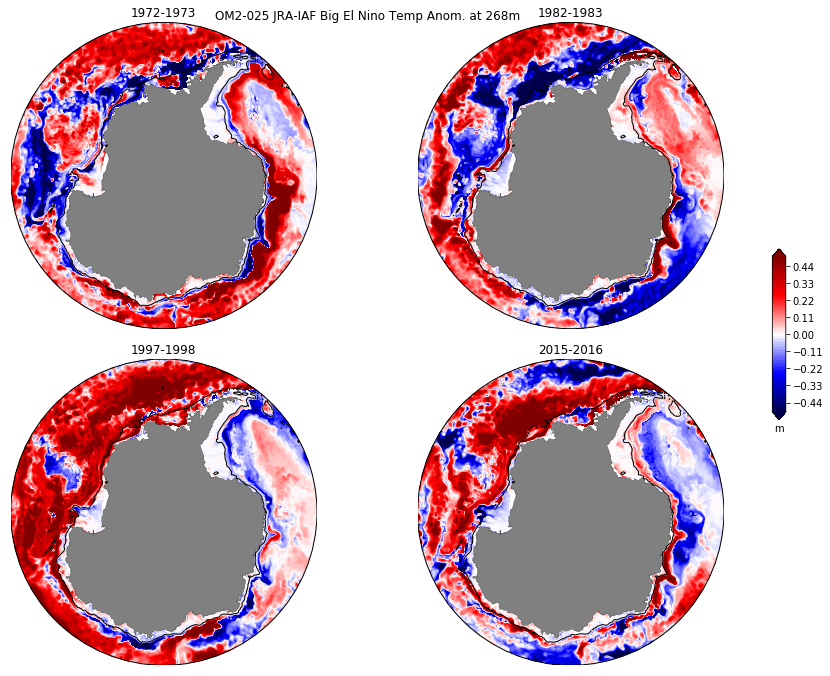

In [88]:
#plot temp anom
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('OM2-025 JRA-IAF Big El Nino Temp Anom. at 268m')
clev = np.arange(-.5,0.51,.01)
yrs=np.arange(1958,2018,1)
#print pert.st_ocean[18]
st=18

yr = nonzero(yrs == 1972)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1982)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1997)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2015)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))


ax3 = plt.axes([0.95,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('m')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'OM2_025_JRA-IAF_Temp_EN_anom.png')
plt.savefig(of,dpi=220)



In [ ]:
1988 1999 2007 2010

1988
30
1999
41
2007
49
2010
52


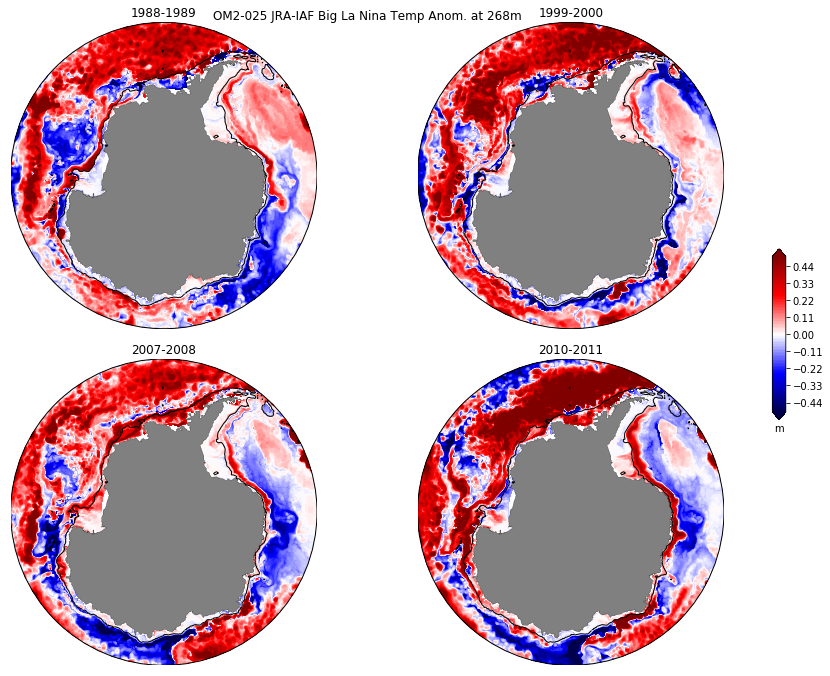

In [89]:
#plot temp anom
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('OM2-025 JRA-IAF Big La Nina Temp Anom. at 268m')
clev = np.arange(-.5,0.51,.01)
yrs=np.arange(1958,2018,1)
#print pert.st_ocean[18]
st=18

yr = nonzero(yrs == 1988)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1999)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2007)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2010)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))


ax3 = plt.axes([0.95,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('m')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'OM2_025_JRA-IAF_Temp_LN_anom.png')
plt.savefig(of,dpi=220)



In [93]:
nc = Dataset('/g/data3/hh5/tmp/pas561/access-om2-jra-iaf/ocean_grid.nc', mode='r') # file handle, open in read only mode
ht = nc.variables['ht'][:,:]
area_t= nc.variables['area_t'][:,:]
nc.close() # close the file
print ht.shape
print area_t.shape

(1080, 1440)
(1080, 1440)


In [95]:
#msk=np.ones((hi_anom_ann.shape[1],hi_anom_ann[2]))
msk=np.ones((250,1440))
msk[np.where(ht[0:250,:]>1000)]=0
msk[np.where(ht[0:250,:]<0)]=0

print np.nansum(area_t)
#print st_ocean[st]

wi1=821
wi2=872
bi1=716
bi2=820
ai1=613
ai2=714

wap_tpert=np.zeros((60,1))
bs_tpert=np.zeros((60,1))
as_tpert=np.zeros((60,1))
for yr in range(0,60):
    print yr
    wap_tpert[yr]=np.nansum(pert.temp[yr,st,0:250,wi1:wi2]*area_t[0:250,wi1:wi2]*msk[:,wi1:wi2])
    warea=np.sum(area_t[0:250,wi1:wi2]*msk[:,wi1:wi2])
    wap_tpert[yr]=wap_tpert[yr]/warea
    
    bs_tpert[yr]=np.nansum(pert.temp[yr,st,0:250,bi1:bi2]*area_t[0:250,bi1:bi2]*msk[:,bi1:bi2])
    barea=np.sum(area_t[0:250,bi1:bi2]*msk[:,bi1:bi2])
    bs_tpert[yr]=bs_tpert[yr]/barea
    
    as_tpert[yr]=np.nansum(pert.temp[yr,st,0:250,ai1:ai2]*area_t[0:250,ai1:ai2]*msk[:,ai1:ai2])
    aarea=np.sum(area_t[0:250,ai1:ai2]*msk[:,ai1:ai2])
    as_tpert[yr]=as_tpert[yr]/aarea
    

4.26866e+14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [96]:
print yrs

[1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972
 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]


(50, 1) (50, 1)
LinregressResult(slope=0.71231024268770926, intercept=-0.00030124726589931053, rvalue=0.28615743121489762, pvalue=0.043946033646890134, stderr=0.344264173324491)
R$^2$=0.08, P=0.04
(50, 1) (50, 1)
LinregressResult(slope=-0.32875681672002133, intercept=-0.029129581119683841, rvalue=-0.096526336463037515, pvalue=0.50487398537707306, stderr=0.48930044046960958)
R$^2$=0.01, P=0.50
(50, 1) (50, 1)
LinregressResult(slope=-0.001003824284718935, intercept=-0.023924745381112594, rvalue=-0.00016732224111431059, pvalue=0.99907986304594854, stderr=0.86593122502577535)
R$^2$=0.00, P=1.00


Text(1970,0.09,u'R$^2$=0.00, P=1.00')

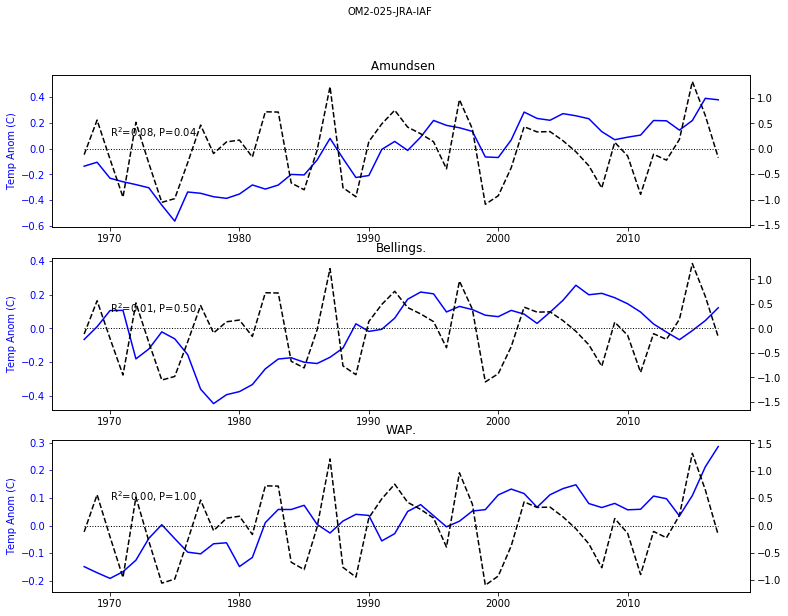

In [99]:
plt.suptitle('OM2-025-JRA-IAF', fontsize=10)

ax1=plt.subplot(311)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title(' Amundsen')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=as_tpert[10:]
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(312)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Bellings.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=bs_tpert[10:]
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(313)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('WAP.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=wap_tpert[10:]
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':
/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app
/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()


(50, 1) (50, 1)
LinregressResult(slope=0.30447649661590642, intercept=-0.029936227157725662, rvalue=0.26427713950564397, pvalue=0.075932510925294378, stderr=0.16751207029256193)
R$^2$=0.07, P=0.08
(50, 1) (50, 1)
LinregressResult(slope=-0.010572745767112637, intercept=-0.0433896299871726, rvalue=-0.0068885076770139487, pvalue=0.96376068850275898, stderr=0.23138009766528114)
R$^2$=0.00, P=0.96
(50, 1) (50, 1)
LinregressResult(slope=0.47739320608088492, intercept=-0.052587937297541548, rvalue=0.14217388156733543, pvalue=0.34592001883437673, stderr=0.50106702204636588)
R$^2$=0.02, P=0.35


Text(1970,0.09,u'R$^2$=0.02, P=0.35')

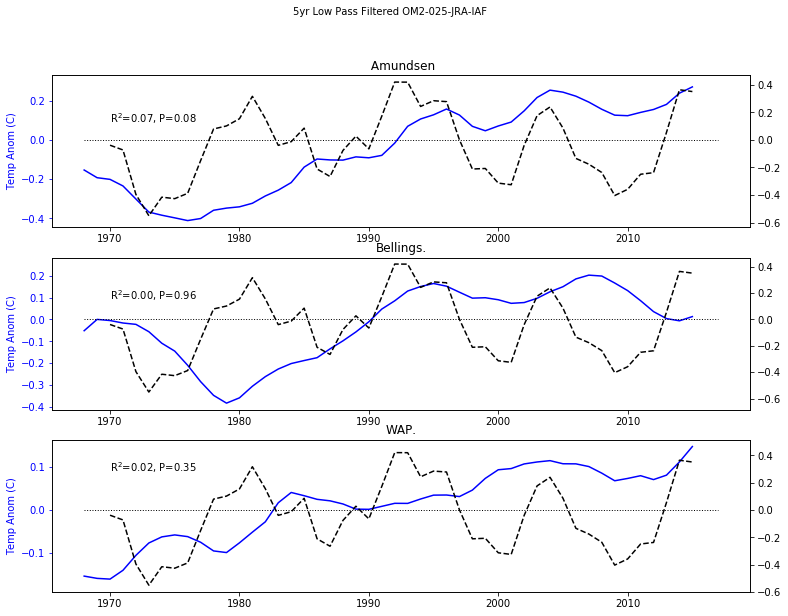

In [101]:
as_tpert_5yr=pd.rolling_mean(as_tpert, window=5, center=True)
bs_tpert_5yr=pd.rolling_mean(bs_tpert, window=5, center=True)
wap_tpert_5yr=pd.rolling_mean(wap_tpert, window=5, center=True)

plt.suptitle('5yr Low Pass Filtered OM2-025-JRA-IAF', fontsize=10)

ax1=plt.subplot(311)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert_5yr[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title(' Amundsen')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=as_tpert_5yr[10:]
b=hadsst_n34_ann_5yr
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(312)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert_5yr[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Bellings.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=bs_tpert_5yr[10:]
b=hadsst_n34_ann_5yr
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(313)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert_5yr[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('WAP.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=wap_tpert_5yr[10:]
b=hadsst_n34_ann_5yr
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)